# Multi-Class Phishing Email Classification with BERT Transformers

### Models Evaluated:
1. **ALBERT** (albert-base-v2) - Parameter-efficient, factorized embeddings
2. **DistilBERT** (distilbert-base-uncased) - 40% smaller, 60% faster than BERT
3. **RoBERTa** (roberta-base) - Robustly optimized BERT pretraining

### Taxonomy (5 Classes):
- **Class 0**: Legitimate emails
- **Class 1**: Commercial/R18 Phishing (medications, marketing, adult content)
- **Class 2**: Monetary Phishing (crypto scams, investments, trust funds)
- **Class 3**: Credential Phishing (fake banking, IT support, account verification)
- **Class 4**: Generic Phishing (fallback category for ambiguous phishing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Setup and Installation

In [2]:
# Mount Google Drive for checkpointing and data storage
from google.colab import drive
import os

drive.mount('/content/drive')

# Create directories
CHECKPOINT_DIR = '/content/drive/MyDrive/thesis_checkpoints'
DATA_DIR = '/content/drive/MyDrive/thesis_data'
RESULTS_DIR = '/content/drive/MyDrive/thesis_results'

for directory in [CHECKPOINT_DIR, DATA_DIR, RESULTS_DIR]:
    os.makedirs(directory, exist_ok=True)

print('✓ Google Drive mounted')
print(f'✓ Checkpoint directory: {CHECKPOINT_DIR}')
print(f'✓ Data directory: {DATA_DIR}')
print(f'✓ Results directory: {RESULTS_DIR}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted
✓ Checkpoint directory: /content/drive/MyDrive/thesis_checkpoints
✓ Data directory: /content/drive/MyDrive/thesis_data
✓ Results directory: /content/drive/MyDrive/thesis_results


In [3]:
# Install required packages
!pip install -q transformers torch scikit-learn pandas numpy matplotlib seaborn datasets accelerate

print('✓ All packages installed successfully')

✓ All packages installed successfully


In [4]:
# Import libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    roc_auc_score,
    roc_curve
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
import time
import json
from datetime import datetime, timedelta
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Print environment information
print('=' * 80)
print('ENVIRONMENT INFORMATION')
print('=' * 80)
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA device: {torch.cuda.get_device_name(0)}')
    print(f'CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
    print(f'CUDA version: {torch.version.cuda}')
else:
    print('⚠️  WARNING: CUDA not available. Training will be very slow on CPU.')
    print('   Please enable GPU in Runtime > Change runtime type > Hardware accelerator > GPU')
print('=' * 80)

ENVIRONMENT INFORMATION
PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA device: NVIDIA A100-SXM4-80GB
CUDA memory: 85.09 GB
CUDA version: 12.8


## 2. Configuration

In [5]:
CONFIG = {
    # File paths (upload these to your Google Drive)
    'benign_file': f'{DATA_DIR}/benign_corpus.csv',
    'consensus_file': f'{DATA_DIR}/consensus_labels.csv',  # Output from annotation consensus notebook

    # Hybrid balancing STRATEGY (Dynamic Ratios)
    # We define ratios relative to original class size instead of hardcoded numbers
    'balancing_ratios': {
        1: 0.3,   # Commercial/R18: Undersample to 30% (reduces dominance)
        2: 1.0,   # Monetary: Keep 100% (already balanced)
        3: 2.0,   # Credential: Oversample 2x (preserve rare patterns)
        4: 1.3    # Generic: Oversample 1.3x (balance representation)
    },

    # Benign ratio: How many benign samples per 1 balanced malicious sample?
    # Target: 67% Benign / 33% Malicious -> Ratio approx 2.0
    'benign_ratio': 1.0,

    # Placeholders (will be calculated dynamically in Data Loading step)
    'balance_targets': {},
    'benign_samples': 0,

    # Models to train
    'models': {
        'roberta': 'roberta-base',
        'distilbert': 'distilbert-base-uncased',
        'albert': 'albert-base-v2'
    },

    # Training hyperparameters (from BERT paper + phishing literature)
    'max_length': 512,           # Maximum token length
    'batch_size': 64,            # Optimized for A100 High RAM with FP16
    'learning_rate': 3e-5,       # Scaled for larger batch size (16 -> 64, 4x -> 2e-5 * 4 = 8e-5)
    'epochs': 10,                # Increased to 10 to allow patience=5 to work
    'warmup_ratio': 0.1,         # 10% linear warmup (prevents instability)
    'weight_decay': 0.01,        # AdamW regularization
    'patience': 4,               # Early stopping patience (epochs)
    'gradient_clip': 1.0,        # Gradient clipping max norm

    # Data split (per thesis Section 4.8)
    'train_size': 0.80,          # 80% for training + CV
    'val_size': 0.10,            # 10% for validation
    'test_size': 0.10,           # 10% for final evaluation

    # Cross-validation
    'n_folds': 5                 # 5-fold stratified CV
}

CLASS_LABELS = {
    0: 'Legitimate',
    1: 'Commercial/R18',
    2: 'Monetary Phishing',
    3: 'Credential Phishing',
    4: 'Generic Phishing'
}

print('\n' + '=' * 80)
print('CONFIGURATION LOADED')
print('=' * 80)
print(f"\nModels to train: {', '.join(CONFIG['models'].keys())}")
print(f"\nData split:")
print(f"  Train: {CONFIG['train_size']*100:.0f}%")
print(f"  Val:   {CONFIG['val_size']*100:.0f}%")
print(f"  Test:  {CONFIG['test_size']*100:.0f}%")
print(f"\nBalancing Strategy:")
for cls, ratio in CONFIG['balancing_ratios'].items():
    print(f"  Class {cls} ({CLASS_LABELS[cls]}): x{ratio}")
print(f"  Benign: x{CONFIG['benign_ratio']} of Total Balanced Malicious")
print(f"\nCross-validation: {CONFIG['n_folds']}-fold stratified")
print(f"\nTraining hyperparameters:")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Epochs: {CONFIG['epochs']}")
print(f"  Warmup ratio: {CONFIG['warmup_ratio']}")
print(f"  Early stopping patience: {CONFIG['patience']} epochs")
print('=' * 80)


CONFIGURATION LOADED

Models to train: roberta, distilbert, albert

Data split:
  Train: 80%
  Val:   10%
  Test:  10%

Balancing Strategy:
  Class 1 (Commercial/R18): x0.3
  Class 2 (Monetary Phishing): x1.0
  Class 3 (Credential Phishing): x2.0
  Class 4 (Generic Phishing): x1.3
  Benign: x1.0 of Total Balanced Malicious

Cross-validation: 5-fold stratified

Training hyperparameters:
  Batch size: 64
  Learning rate: 3e-05
  Epochs: 10
  Warmup ratio: 0.1
  Early stopping patience: 4 epochs


## 3. Data Loading and Exploration

### Data Sources:
1. **benign_corpus.csv**: Pre-labeled legitimate emails (~39,000) from multiple datasets:
   - Enron Email Dataset
   - Ling-Spam Corpus
   - SpamAssassin Public Corpus
   - Other academic datasets

2. **consensus_labels.csv**: Malicious emails with consensus labels from weighted voting:
   - Generated by `3_Annotation_Consensus.ipynb`
   - Contains both annotated and unannotated samples
   - We filter to use **ONLY annotated samples** (non-NaN labels)

### Important:
The 26,916 unannotated malicious emails are **discarded** to avoid:
- Semantic degradation from mislabeling
- Class 4 bias (if assigned to Generic)
- Unreliable training signal

This decision prioritizes **data quality over quantity**, following best practices for supervised learning.

In [6]:
print('\n' + '=' * 80)
print('LOADING DATA')
print('=' * 80)

# Load benign emails
print('\n1. Loading benign emails...')
benign_df = pd.read_csv(CONFIG['benign_file'])
print(f"   ✓ Loaded: {len(benign_df):,} benign emails")

# Check for source diversity
if 'source_dataset' in benign_df.columns:
    print(f"   ✓ Sources: {benign_df['source_dataset'].nunique()} datasets")
    print(f"\n   Source distribution:")
    for source, count in benign_df['source_dataset'].value_counts().items():
        print(f"     - {source}: {count:,} emails")

# Ensure benign label
benign_df['label'] = 0

# Load malicious emails (consensus from annotation notebook)
print('\n2. Loading malicious emails (with consensus labels)...')
malicious_df = pd.read_csv(CONFIG['consensus_file'])
print(f"   ✓ Total malicious emails in file: {len(malicious_df):,}")

# Identify the annotation column dynamically
possible_label_cols = ['annotation_label', 'consensus_label', 'final_label', 'label']
label_col = None

for col in possible_label_cols:
    if col in malicious_df.columns:
        label_col = col
        print(f"   ✓ Found label column: '{label_col}'")
        break

if label_col is None:
    print(f"   ⚠️ Could not find label column. Available columns: {malicious_df.columns.tolist()}")
    raise KeyError(f"None of {possible_label_cols} found in consensus file.")

# Filter to ONLY annotated samples (non-NaN labels)
annotated_df = malicious_df[malicious_df[label_col].notna()].copy()

# Map annotation_label to label column for consistency
annotated_df['label'] = annotated_df[label_col].astype(int)

# CRITICAL: Unify text column. Benign has 'text_cleaned'; consensus_labels.csv has 'text'.
# Without this, malicious rows get NaN in text_cleaned after merge; model sees literal "nan" for all phishing -> class collapse.
if 'text_cleaned' not in annotated_df.columns and 'text' in annotated_df.columns:
    annotated_df['text_cleaned'] = annotated_df['text'].fillna('').astype(str)
    print("   ✓ Using 'text' as text_cleaned for malicious (consensus file)")
elif 'text_cleaned' in annotated_df.columns:
    annotated_df['text_cleaned'] = annotated_df['text_cleaned'].fillna('').astype(str)
else:
    raise ValueError("Malicious data has neither 'text' nor 'text_cleaned'. Available: " + str(annotated_df.columns.tolist()))

unannotated_count = len(malicious_df) - len(annotated_df)

print(f"\n   Annotation coverage:")
print(f"     - Annotated:   {len(annotated_df):,} ({len(annotated_df)/len(malicious_df)*100:.1f}%)")
print(f"     - Unannotated: {unannotated_count:,} ({unannotated_count/len(malicious_df)*100:.1f}%)")
print(f"\n   ✓ Using {len(annotated_df):,} annotated samples")
print(f"   ✗ Discarding {unannotated_count:,} unannotated samples")

# Display raw class distribution BEFORE balancing
print('\n' + '=' * 80)
print('RAW ANNOTATED CLASS DISTRIBUTION (Before Balancing)')
print('=' * 80)
print(f"{'Class':<6} {'Label':<25} {'Count':>8} {'Percentage':>12}")
print('-' * 80)
for label in sorted(annotated_df['label'].unique()):
    count = (annotated_df['label'] == label).sum()
    pct = count / len(annotated_df) * 100
    class_name = CLASS_LABELS[int(label)]
    print(f"{int(label):<6} {class_name:<25} {count:>8,} {pct:>11.1f}%")

print('-' * 80)
print(f"{'TOTAL':<6} {'Malicious (Annotated)':<25} {len(annotated_df):>8,} {100.0:>11.1f}%")
print('=' * 80)

# Calculate imbalance ratios
class_counts = annotated_df['label'].value_counts().sort_index()
max_class = class_counts.max()
min_class = class_counts.min()
print(f"\nImbalance Analysis:")
print(f"  Largest class: {max_class:,} samples (Class {class_counts.idxmax()})")
print(f"  Smallest class: {min_class:,} samples (Class {class_counts.idxmin()})")
print(f"  Imbalance ratio: {max_class/min_class:.1f}:1")
print(f"\n  ⚠️  This {max_class/min_class:.1f}:1 imbalance requires hybrid resampling strategy")
print('=' * 80)

# DYNAMIC BALANCING CALCULATION
print('\n' + '=' * 80)
print('CALCULATING DYNAMIC BALANCING TARGETS')
print('=' * 80)

# FAILSAFE: Ensure balancing_ratios exist in CONFIG
if 'balancing_ratios' not in CONFIG:
    print("⚠️  'balancing_ratios' not found in CONFIG (Cell not run?). Using default values.")
    CONFIG['balancing_ratios'] = {
        1: 0.3,   # Commercial/R18
        2: 1.0,   # Monetary
        3: 2.0,   # Credential
        4: 1.3    # Generic
    }
    CONFIG['benign_ratio'] = 2.0

total_malicious_balanced = 0
class_counts = annotated_df['label'].value_counts()

print(f"{'Class':<6} {'Label':<25} {'Original':>10} {'Ratio':>8} {'Target':>10}")
print('-' * 70)

# Reset targets to ensure clean calculation
CONFIG['balance_targets'] = {}

for label in sorted(CONFIG['balancing_ratios'].keys()):
    count = class_counts.get(label, 0)
    ratio = CONFIG['balancing_ratios'][label]
    target = int(count * ratio)

    # Ensure target is at least 1 if original count > 0, else 0
    if count > 0 and target == 0:
        target = 1

    CONFIG['balance_targets'][label] = target
    total_malicious_balanced += target

    class_name = CLASS_LABELS.get(label, str(label))
    print(f"{label:<6} {class_name:<25} {count:>10,} {ratio:>8.1f} {target:>10,}")

# Calculate Benign target
CONFIG['benign_samples'] = int(total_malicious_balanced * CONFIG['benign_ratio'])

print('-' * 70)
print(f"{'TOTAL':<6} {'Malicious (Balanced)':<25} {'':>10} {'':>8} {total_malicious_balanced:>10,}")
print(f"{'TOTAL':<6} {'Benign Target':<25} {'':>10} {'':>8} {CONFIG['benign_samples']:>10,} (Ratio: {CONFIG['benign_ratio']}x)")
print('=' * 80)


LOADING DATA

1. Loading benign emails...
   ✓ Loaded: 39,191 benign emails
   ✓ Sources: 4 datasets

   Source distribution:
     - CEAS_08: 17,233 emails
     - Enron: 15,470 emails
     - SpamAssassin: 4,087 emails
     - Ling-Spam: 2,401 emails

2. Loading malicious emails (with consensus labels)...
   ✓ Total malicious emails in file: 9,116
   ✓ Found label column: 'label'

   Annotation coverage:
     - Annotated:   9,116 (100.0%)
     - Unannotated: 0 (0.0%)

   ✓ Using 9,116 annotated samples
   ✗ Discarding 0 unannotated samples

RAW ANNOTATED CLASS DISTRIBUTION (Before Balancing)
Class  Label                        Count   Percentage
--------------------------------------------------------------------------------
1      Commercial/R18               5,857        64.2%
2      Monetary Phishing            1,654        18.1%
3      Credential Phishing            644         7.1%
4      Generic Phishing               961        10.5%
----------------------------------------------

## 4. Hybrid Balancing Strategy

### Problem:
Severe class imbalance (8.8:1 ratio) causes BERT to:
- Ignore minority classes (Credential Phishing)
- Overfit to majority class (Commercial/R18)
- Achieve high accuracy but poor Macro F1

### Solution: Hybrid Resampling (Data-Level + Algorithm-Level)

#### Step 1: Data-Level Balancing
1. **Undersample Majority**
   - Reduces dominance without discarding all data
   - Speeds up training by 50%

2. **Keep Middle Classes**
   - Already reasonably sized
   - Preserves all authentic samples

3. **Oversample Minorities**
   - Preserves rare phishing patterns

4. **Undersample Benign**:
   - Shuffle BEFORE sampling for source diversity
   - Maintains 67/33 benign/malicious ratio

#### Step 2: Algorithm-Level Balancing
- Apply **class-weighted loss** even after resampling
- Weights inversely proportional to class frequency
- Double protection for minority classes

In [8]:
print('\n' + '=' * 80)
print('APPLYING HYBRID BALANCING STRATEGY')
print('=' * 80)

# STEP 1: Shuffle benign corpus for dataset diversity
# CRITICAL: Benign data may be ordered by source (e.g., all Enron, then all Ling-Spam)
# Shuffling ensures sampled subset represents all sources
print('\n1. Shuffling benign corpus for source diversity...')
benign_shuffled = benign_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
print(f"   ✓ Shuffled {len(benign_shuffled):,} benign emails (seed={SEED})")

# Undersample benign
benign_sampled = benign_shuffled.sample(n=CONFIG['benign_samples'], random_state=SEED)
print(f"   ✓ Sampled {len(benign_sampled):,} benign emails")
print(f"     (Target: {CONFIG['benign_samples']:,} = 2× total malicious)")

# Verify source diversity in sampled benign
if 'source_dataset' in benign_sampled.columns:
    print(f"\n   Source distribution in sampled benign:")
    for source, count in benign_sampled['source_dataset'].value_counts().items():
        pct = count / len(benign_sampled) * 100
        print(f"     - {source}: {count:,} ({pct:.1f}%)")

# STEP 2: Apply hybrid sampling to malicious classes
print('\n2. Applying hybrid resampling to malicious classes...')
print('\n   Strategy:')
print('   - Undersample: Reduce majority class to prevent dominance')
print('   - Oversample:  Duplicate minorities to preserve rare patterns')
print('   - Keep:        Maintain classes already balanced')
print()
print(f"   {'Class':<6} {'Label':<25} {'Original':>10} {'→':>3} {'Target':>10} {'Action':<20}")
print('   ' + '-' * 80)

sampled_malicious = []

for label, target_count in sorted(CONFIG['balance_targets'].items()):
    class_df = annotated_df[annotated_df['label'] == label].copy()
    original_count = len(class_df)
    class_name = CLASS_LABELS[label]

    if original_count > target_count:
        # Undersample majority class
        class_sampled = class_df.sample(n=target_count, random_state=SEED)
        action = f"UNDERSAMPLE ({original_count/target_count:.1f}x reduction)"
    elif original_count < target_count:
        # Oversample minority class with replacement
        class_sampled = class_df.sample(n=target_count, replace=True, random_state=SEED)
        action = f"OVERSAMPLE ({target_count/original_count:.1f}x duplication)"
    else:
        # Keep as-is
        class_sampled = class_df
        action = "KEEP (already balanced)"

    sampled_malicious.append(class_sampled)
    print(f"   {label:<6} {class_name:<25} {original_count:>10,} {'→':>3} {target_count:>10,} {action:<20}")

print('   ' + '-' * 80)

# Merge all sampled malicious
malicious_balanced = pd.concat(sampled_malicious, ignore_index=True)
print(f"   {'TOTAL':<6} {'Malicious (Balanced)':<25} {len(annotated_df):>10,} {'→':>3} {len(malicious_balanced):>10,}")

# STEP 3: Merge benign + malicious and final shuffle
print('\n3. Merging datasets and final shuffle...')
full_df = pd.concat([benign_sampled, malicious_balanced], ignore_index=True)
full_df = full_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
print(f"   ✓ Final dataset: {len(full_df):,} samples (shuffled)")

# Display final balanced distribution
print('\n' + '=' * 80)
print('FINAL BALANCED DATASET')
print('=' * 80)
print(f"\nTotal samples: {len(full_df):,}\n")
print(f"{'Class':<6} {'Label':<25} {'Count':>8} {'Percentage':>12}")
print('-' * 80)

for label in sorted(full_df['label'].unique()):
    count = (full_df['label'] == label).sum()
    pct = count / len(full_df) * 100
    class_name = CLASS_LABELS[int(label)]
    print(f"{int(label):<6} {class_name:<25} {count:>8,} {pct:>11.1f}%")

total_malicious = len(malicious_balanced)
total_benign = len(benign_sampled)
print('-' * 80)
print(f"{'SUB':<6} {'Benign':<25} {total_benign:>8,} {total_benign/len(full_df)*100:>11.1f}%")
print(f"{'TOTAL':<6} {'Malicious':<25} {total_malicious:>8,} {total_malicious/len(full_df)*100:>11.1f}%")
print('=' * 80)
print(f"\nBenign:Malicious ratio = {total_benign/total_malicious:.2f}:1")
print(f"\n✓ Dataset balanced and ready for training")
print('=' * 80)


APPLYING HYBRID BALANCING STRATEGY

1. Shuffling benign corpus for source diversity...
   ✓ Shuffled 39,191 benign emails (seed=42)
   ✓ Sampled 5,948 benign emails
     (Target: 5,948 = 2× total malicious)

   Source distribution in sampled benign:
     - CEAS_08: 2,564 (43.1%)
     - Enron: 2,407 (40.5%)
     - SpamAssassin: 634 (10.7%)
     - Ling-Spam: 343 (5.8%)

2. Applying hybrid resampling to malicious classes...

   Strategy:
   - Undersample: Reduce majority class to prevent dominance
   - Oversample:  Duplicate minorities to preserve rare patterns
   - Keep:        Maintain classes already balanced

   Class  Label                       Original   →     Target Action              
   --------------------------------------------------------------------------------
   1      Commercial/R18                 5,857   →      1,757 UNDERSAMPLE (3.3x reduction)
   2      Monetary Phishing              1,654   →      1,654 KEEP (already balanced)
   3      Credential Phishing        

## 5. Compute Class Weights

Even after hybrid resampling, we **still apply class weights** to the loss function. This dual approach (data-level + algorithm-level balancing) is recommended for BERT fine-tuning on imbalanced data.

### Why Class Weights After Resampling?
1. **Residual Imbalance**: Benign (67%) still larger than any single malicious class
2. **Fine-Grained Adjustment**: Weights fine-tune the already-balanced distribution
3. **Overfitting Protection**: Prevents model from memorizing oversampled duplicates
4. **Best Practice**: Literature shows hybrid approach outperforms either alone

### Weight Calculation:
$$w_i = \frac{n_{samples}}{n_{classes} \times n_{samples\_class\_i}}$$

Higher weights for smaller classes → model pays more attention to their errors.

In [9]:
# Compute class weights for the training data to handle imbalance (algorithm-level balancing)
# Weights are inversely proportional to class frequencies

# Determine which dataset to use for weight calculation
# Ideally y_train (from Section 6), but fallback to full_df (from Section 4) if not yet split
if 'y_train' in locals():
    target_y = y_train
    source_name = "Training Set (y_train)"
elif 'full_df' in locals():
    target_y = full_df['label'].values
    source_name = "Full Balanced Dataset (full_df) - Approximate"
else:
    raise ValueError("Neither y_train nor full_df is defined. Please run data loading/balancing cells first.")

# Compute class weights using sklearn's utility
# 'balanced' mode automatically calculates weights inversely proportional to class frequencies
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(target_y),
    y=target_y
)

# Convert to PyTorch tensor and move to device
# This tensor will be passed to the CrossEntropyLoss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = torch.tensor(class_weights_array, dtype=torch.float).to(device)

print('\n' + '=' * 80)
print('CLASS WEIGHTS COMPUTED')
print('=' * 80)
print(f"Source: {source_name}")
print(f"Computed class weights (for {len(CLASS_LABELS)} classes):")
for i, weight in enumerate(class_weights_array):
    print(f"  Class {i} ({CLASS_LABELS[i]}): {weight:.4f}")
print(f"Total samples for weight calculation: {len(target_y):,}")
print('=' * 80)


CLASS WEIGHTS COMPUTED
Source: Full Balanced Dataset (full_df) - Approximate
Computed class weights (for 5 classes):
  Class 0 (Legitimate): 0.4000
  Class 1 (Commercial/R18): 1.3541
  Class 2 (Monetary Phishing): 1.4385
  Class 3 (Credential Phishing): 1.8472
  Class 4 (Generic Phishing): 1.9049
Total samples for weight calculation: 11,896


## 6. Train/Validation/Test Split (80/10/10)

Following thesis methodology (Section 4.8):

### Split Strategy:
```
Original Data (100%)
├─ Train Set (80%) ← Used for 5-fold CV and final model training
├─ Validation Set (10%) ← Used for hyperparameter tuning and early stopping
└─ Test Set (10%) ← NEVER touched until final evaluation (unbiased)
```

### Implementation:
1. First split: 80% train, 20% temp
2. Second split: Split temp into 50/50 → 10% val, 10% test

All splits are **stratified** to maintain class proportions across splits.

In [10]:
print('\n' + '=' * 80)
print('TRAIN/VALIDATION/TEST SPLIT (80/10/10 Stratified)')
print('=' * 80)

# Determine text column
text_col = 'text_cleaned'
if text_col not in full_df.columns:
    # Fallback to likely alternatives
    for col in ['text', 'body', 'content', 'email']:
        if col in full_df.columns:
            text_col = col
            print(f"⚠️ 'text_cleaned' not found. Using '{text_col}' instead.")
            break

if text_col not in full_df.columns:
    raise ValueError(f"Could not find text column. Available columns: {full_df.columns.tolist()}")

# Extract features and labels
# Ensure text is string (handle NaNs if any)
X = full_df[text_col].astype(str).values
y = full_df['label'].values.astype(int)

print(f"\nTotal samples: {len(X):,}")
print(f"Feature column: '{text_col}'")
print(f"Label column: 'label' (0-4)")

# First split: 80% train, 20% temp (for val+test)
print('\n1. First split: 80% train, 20% temporary...')
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=(CONFIG['val_size'] + CONFIG['test_size']),  # 0.20
    stratify=y,
    random_state=SEED
)
print(f"   ✓ Training: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   ✓ Temporary: {len(X_temp):,} samples ({len(X_temp)/len(X)*100:.1f}%)")

# Second split: Split temp into 50/50 (10% val, 10% test of original)
print('\n2. Second split: Split temporary into 50/50 (val/test)...')
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,  # 50% of temp = 10% of original
    stratify=y_temp,
    random_state=SEED
)
print(f"   ✓ Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   ✓ Test: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Summary
print('\n' + '=' * 80)
print('SPLIT SUMMARY')
print('=' * 80)
print(f"\n{'Split':<15} {'Samples':>10} {'Percentage':>12} {'Purpose':<30}")
print('-' * 80)
print(f"{'Training':<15} {len(X_train):>10,} {len(X_train)/len(X)*100:>11.1f}% {'5-fold CV + final training':<30}")
print(f"{'Validation':<15} {len(X_val):>10,} {len(X_val)/len(X)*100:>11.1f}% {'Early stopping & tuning':<30}")
print(f"{'Test':<15} {len(X_test):>10,} {len(X_test)/len(X)*100:>11.1f}% {'Final unbiased evaluation':<30}")
print('-' * 80)
print(f"{'TOTAL':<15} {len(X):>10,} {100.0:>11.1f}%")
print('=' * 80)

# Verify stratification
print('\nVerifying Stratification (class distributions should be similar):')
print(f"\n{'Class':<6} {'Label':<25} {'Train %':>10} {'Val %':>10} {'Test %':>10}")
print('-' * 80)
for label in sorted(np.unique(y)):
    train_pct = (y_train == label).sum() / len(y_train) * 100
    val_pct = (y_val == label).sum() / len(y_val) * 100
    test_pct = (y_test == label).sum() / len(y_test) * 100
    class_name = CLASS_LABELS[label]
    print(f"{label:<6} {class_name:<25} {train_pct:>9.1f}% {val_pct:>9.1f}% {test_pct:>9.1f}%")
print('=' * 80)

print('\n✓ Data split complete and verified')
print('✓ Stratification ensures balanced class representation across all splits')


TRAIN/VALIDATION/TEST SPLIT (80/10/10 Stratified)

Total samples: 11,896
Feature column: 'text_cleaned'
Label column: 'label' (0-4)

1. First split: 80% train, 20% temporary...
   ✓ Training: 9,516 samples (80.0%)
   ✓ Temporary: 2,380 samples (20.0%)

2. Second split: Split temporary into 50/50 (val/test)...
   ✓ Validation: 1,190 samples (10.0%)
   ✓ Test: 1,190 samples (10.0%)

SPLIT SUMMARY

Split              Samples   Percentage Purpose                       
--------------------------------------------------------------------------------
Training             9,516        80.0% 5-fold CV + final training    
Validation           1,190        10.0% Early stopping & tuning       
Test                 1,190        10.0% Final unbiased evaluation     
--------------------------------------------------------------------------------
TOTAL               11,896       100.0%

Verifying Stratification (class distributions should be similar):

Class  Label                        Train %   

## 7. Dataset and DataLoader Classes

### Key Design Decisions:

1. **No Padding in Dataset**: Individual samples returned without padding
2. **Dynamic Padding in DataLoader**: `DataCollatorWithPadding` pads each batch to longest sequence
3. **Benefits**:
   - Reduces computation on padding tokens by ~30%
   - Different batch lengths adapt to actual content
   - Faster training without accuracy loss

In [11]:
class PhishingDataset(Dataset):
    """
    Custom Dataset for phishing email classification.

    Returns tokenized samples WITHOUT padding (padding handled by DataCollatorWithPadding).
    This enables dynamic batch-wise padding for computational efficiency.

    Args:
        texts (array): Email text samples
        labels (array): Integer class labels (0-4)
        tokenizer: HuggingFace tokenizer
        max_length (int): Maximum sequence length (default: 512)
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize without padding (padding done by collator)
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_length,
            padding=False,  # CRITICAL: No padding here
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

print('✓ PhishingDataset class defined')
print('  - Dynamic padding enabled (reduces computation by ~30%)')
print('  - Max length: 512 tokens')
print('  - Returns: input_ids, attention_mask, labels')

✓ PhishingDataset class defined
  - Dynamic padding enabled (reduces computation by ~30%)
  - Max length: 512 tokens
  - Returns: input_ids, attention_mask, labels


## 8. Training Functions

### Advanced Training Features:

1. **Mixed Precision (FP16)**:
   - Uses `torch.cuda.amp.autocast` and `GradScaler`
   - 30-40% faster training
   - 50% less GPU memory
   - No accuracy loss (Micikevicius et al., 2018)

2. **Gradient Clipping**:
   - Max norm = 1.0
   - Prevents exploding gradients
   - Standard for transformers (Pascanu et al., 2013)

3. **Learning Rate Warmup**:
   - Linear increase: 0 → 2e-5 (first 10% steps)
   - Then linear decay: 2e-5 → 0 (remaining 90%)
   - Prevents early training instability (Goyal et al., 2017)

4. **AdamW Optimizer**:
   - Fixes Adam's weight decay implementation
   - Standard for BERT fine-tuning (Loshchilov & Hutter, 2019)

5. **Early Stopping on Macro F1** (NOT Accuracy):
   - Accuracy misleading with class imbalance
   - Macro F1 equally weights all classes
   - Prevents bias toward majority class

In [12]:
def train_epoch(model, loader, optimizer, scheduler, scaler, device, class_weights):
    """
    Train for one epoch with mixed precision and class-weighted loss.

    IMPORTANT: Computes weighted CrossEntropyLoss manually to ensure minority classes
    are weighted properly. HuggingFace model's default loss doesn't use custom weights.

    Args:
        model: HuggingFace transformer model
        loader: Training DataLoader
        optimizer: AdamW optimizer
        scheduler: Learning rate scheduler with warmup
        scaler: GradScaler for mixed precision
        device: torch device (cuda/cpu)
        class_weights: Tensor of class weights for weighted loss

    Returns:
        avg_loss (float): Average training loss
        accuracy (float): Training accuracy
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Define loss function once per epoch, potentially moving weights to device
    if class_weights is not None:
        # Ensure class_weights is on the correct device for loss computation
        class_weights_on_device = class_weights.to(device)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_on_device)
    else:
        loss_fct = nn.CrossEntropyLoss()  # Unweighted

    for batch_idx, batch in enumerate(loader):
        optimizer.zero_grad()

        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass with mixed precision (FP16)
        with autocast():
            # Get model outputs WITHOUT computing loss
            # (we'll compute weighted loss manually)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Compute the loss using the pre-defined loss_fct
            loss = loss_fct(outputs.logits, labels)

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient clipping (unscale gradients first)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])

        # Optimizer step
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Track metrics
        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total

    return avg_loss, accuracy

## 9. Main Training Loop with Early Stopping

### Training Workflow:
1. Load pretrained model from HuggingFace
2. Create datasets and dataloaders (with dynamic padding)
3. Initialize optimizer (AdamW) and scheduler (linear warmup + decay)
4. Train for max 4 epochs with early stopping (patience=2)
5. Monitor **Macro F1** on validation set (not accuracy!)
6. Save best checkpoint to Google Drive
7. Return trained model and metrics

In [13]:
def evaluate(model, loader, device):
    """
    Evaluates the model on a given dataset.

    Args:
        model: HuggingFace transformer model
        loader: DataLoader for the evaluation set
        device: torch device (cuda/cpu)

    Returns:
        all_preds (np.array): Predicted class labels
        all_labels (np.array): True class labels
        all_probs (np.array): Predicted probabilities for each class
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with autocast(): # Use mixed precision for evaluation as well
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

def compute_metrics(labels, preds, probs):
    """
    Computes a comprehensive set of classification metrics.

    Args:
        labels (np.array): True labels
        preds (np.array): Predicted labels
        probs (np.array): Predicted probabilities for each class

    Returns:
        dict: Dictionary of computed metrics.
    """
    metrics = {}

    # Overall metrics
    metrics['accuracy'] = accuracy_score(labels, preds)

    # Macro-averaged metrics (equal weight to each class)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    metrics['macro_precision'] = precision_macro
    metrics['macro_recall'] = recall_macro
    metrics['macro_f1'] = f1_macro

    # Weighted-averaged metrics (weighted by support)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        labels, preds, average='weighted', zero_division=0
    )
    metrics['weighted_precision'] = precision_weighted
    metrics['weighted_recall'] = recall_weighted
    metrics['weighted_f1'] = f1_weighted

    # Cohen's Kappa
    metrics['cohen_kappa'] = cohen_kappa_score(labels, preds)

    # AUC-ROC (One-vs-Rest for multi-class)
    num_classes = len(np.unique(labels)) # Use unique labels to determine actual number of classes present
    if probs.shape[1] > 1: # Check if probabilities are multi-class
        try:
            # Binarize labels for roc_auc_score
            binarized_labels = label_binarize(labels, classes=np.arange(probs.shape[1]))
            metrics['auc_macro'] = roc_auc_score(binarized_labels, probs, average='macro')
            metrics['auc_weighted'] = roc_auc_score(binarized_labels, probs, average='weighted')
        except ValueError:
            metrics['auc_macro'] = np.nan # Not enough samples of a class to compute AUC
            metrics['auc_weighted'] = np.nan
    else:
        # For binary classification scenarios where only one column of probs is returned
        metrics['auc_macro'] = roc_auc_score(labels, probs[:, 1] if probs.ndim > 1 else probs)
        metrics['auc_weighted'] = metrics['auc_macro'] # Same for binary

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0
    )
    metrics['per_class_precision'] = precision_per_class
    metrics['per_class_recall'] = recall_per_class
    metrics['per_class_f1'] = f1_per_class

    return metrics

def train_model(model_name, model_id, X_tr, y_tr, X_val, y_val, class_weights=None, fold=None):
    """
    Train a single model with early stopping on Macro F1.

    Args:
        model_name: Short name for saving (e.g., 'albert', 'distilbert')
        model_id: HuggingFace model identifier (e.g., 'albert-base-v2')
        X_tr, y_tr: Training data (texts, labels)
        X_val, y_val: Validation data (texts, labels)
        class_weights: Tensor of class weights for weighted loss (optional)
        fold: Fold number for CV (None for final training)

    Returns:
        model: Best trained model
        history: Training history (loss, accuracy, F1 per epoch)
        best_f1: Best validation Macro F1 score
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load tokenizer and model
    print(f"\n  Loading tokenizer and model: {model_id}...")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=len(CLASS_LABELS)
    )
    model.to(device)
    print(f"  ✓ Model loaded ({sum(p.numel() for p in model.parameters()):,} parameters)")

    # Create datasets
    train_dataset = PhishingDataset(X_tr, y_tr, tokenizer, CONFIG['max_length'])
    val_dataset = PhishingDataset(X_val, y_val, tokenizer, CONFIG['max_length'])

    # Dynamic padding collator
    collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        collate_fn=collator,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        collate_fn=collator,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # Optimizer and scheduler
    optimizer = AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )

    total_steps = len(train_loader) * CONFIG['epochs']
    warmup_steps = int(total_steps * CONFIG['warmup_ratio'])

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    print(f"  ✓ Optimizer: AdamW (lr={CONFIG['learning_rate']}, weight_decay={CONFIG['weight_decay']})")
    print(f"  ✓ Scheduler: Linear warmup ({warmup_steps} steps) + linear decay ({total_steps} total steps)")

    if class_weights is not None:
        print(f"  ✓ Class Weights Applied: {class_weights.tolist()}")

    # Mixed precision scaler
    scaler = GradScaler()

    # Training state
    best_f1 = 0.0
    patience_counter = 0
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_macro_f1': [],
        'val_acc': []
    }

    fold_str = f"Fold {fold}" if fold is not None else "Final Training"
    print(f"\n  {'-'*76}")
    print(f"  {fold_str} - {model_name.upper()}")
    print(f"  {'-'*76}")

    # Training loop
    for epoch in range(CONFIG['epochs']):
        epoch_start = time.time()

        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, scheduler, scaler, device, class_weights
        )

        # Validate
        val_preds, val_labels, val_probs = evaluate(model, val_loader, device)
        val_metrics = compute_metrics(val_labels, val_preds, val_probs)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_macro_f1'].append(val_metrics['macro_f1'])
        history['val_acc'].append(val_metrics['accuracy'])

        epoch_time = time.time() - epoch_start

        print(f"  Epoch {epoch+1}/{CONFIG['epochs']} ({epoch_time:.1f}s) - "
              f"Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val F1: {val_metrics['macro_f1']:.4f} | Val Acc: {val_metrics['accuracy']:.4f}")

        # Early stopping based on Macro F1 (not accuracy)
        if val_metrics['macro_f1'] > best_f1:
            best_f1 = val_metrics['macro_f1']
            patience_counter = 0

            # Save best model checkpoint
            fold_suffix = f"_fold{fold}" if fold is not None else ""
            checkpoint_path = f"{CHECKPOINT_DIR}/{model_name}{fold_suffix}_best.pt"

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'best_f1': best_f1,
                'metrics': val_metrics,
                'history': history
            }, checkpoint_path)

            print(f"    ✓ Best model saved (Macro F1: {best_f1:.4f})")
        else:
            patience_counter += 1
            print(f"    Patience: {patience_counter}/{CONFIG['patience']} (best F1: {best_f1:.4f})")

            if patience_counter >= CONFIG['patience']:
                print(f"\n    🛑 Early stopping triggered at epoch {epoch+1}")
                print(f"    Best validation Macro F1: {best_f1:.4f}")
                break

    print(f"  {'-'*76}")
    return model, history, best_f1

print('✓ Main training function defined')
print(f'  - Early stopping on Macro F1 (patience={CONFIG["patience"]})')
print('  - Checkpointing to Google Drive')
print('  - Mixed precision training (FP16)')
print('  - Explicit Class Weights Support')

✓ Main training function defined
  - Early stopping on Macro F1 (patience=4)
  - Checkpointing to Google Drive
  - Mixed precision training (FP16)
  - Explicit Class Weights Support


## 10. 5-Fold Cross-Validation

### Why 5-Fold?
- **Optimal for 10k-15k samples** (Kohavi, 1995)
- **Balanced bias-variance tradeoff**:
  - 3-fold: High bias, too coarse
  - 5-fold: Good balance
  - 10-fold: Lower bias, but 2× compute with minimal benefit
- **Each fold**: ~2,526 validation samples (~500 per class)
- **Stratified**: Maintains class proportions in each fold

### Expected Runtime:
- **DistilBERT**: ~1.5-2 hours (5 folds × 20-25 min/fold)
- **ALBERT**: ~2-2.5 hours
- **RoBERTa**: ~4-5 hours
- **Total**: ~8-9 hours

### Pro Tip:
Colab free tier has ~12-hour session limit. You may need 2-3 sessions:
1. Session 1: Train DistilBERT + ALBERT
2. Session 2: Train RoBERTa
3. All checkpoints saved to Google Drive (survives disconnections)

In [14]:
print('\n' + '=' * 80)
print('5-FOLD STRATIFIED CROSS-VALIDATION')
print('=' * 80)
print('\nThis will train each model 5 times (one per fold).')
print('Expected runtime: ~8-9 hours total on Colab T4 GPU with FP16.')
print('\nAll checkpoints saved to Google Drive: survives Colab disconnections.')
print('=' * 80)

cv_results = {}
skf = StratifiedKFold(n_splits=CONFIG['n_folds'], shuffle=True, random_state=SEED)

# Train each model
for model_name, model_id in CONFIG['models'].items():
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_name.upper()} ({model_id})")
    print(f"{'='*80}")

    fold_scores = []
    model_start_time = time.time()

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
        print(f"\n{'-'*80}")
        print(f"FOLD {fold}/{CONFIG['n_folds']}")
        print(f"{'='*80}")

        # Split data
        X_tr, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_tr, y_val_fold = y_train[train_idx], y_train[val_idx]

        print(f"  Training samples: {len(X_tr):,}")
        print(f"  Validation samples: {len(X_val_fold):,}")

        # Compute class weights for this specific fold
        fold_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_tr),
            y=y_tr
        )
        fold_weights_tensor = torch.tensor(fold_weights, dtype=torch.float)
        print(f"  Class Weights (Fold {fold}): {[f'{w:.4f}' for w in fold_weights]}")

        # Train model
        model, history, best_f1 = train_model(
            model_name, model_id, X_tr, y_tr, X_val_fold, y_val_fold,
            class_weights=fold_weights_tensor,
            fold=fold
        )

        fold_scores.append(best_f1)
        print(f"\n  ✓ Fold {fold} complete - Best Macro F1: {best_f1:.4f}")

        # Clear CUDA cache to prevent OOM
        del model
        torch.cuda.empty_cache()

    # Compute CV statistics
    mean_f1 = np.mean(fold_scores)
    std_f1 = np.std(fold_scores)
    model_time = time.time() - model_start_time

    cv_results[model_name] = {
        'mean_f1': mean_f1,
        'std_f1': std_f1,
        'fold_scores': fold_scores,
        'training_time': model_time
    }

    print(f"\n{'='*80}")
    print(f"{model_name.upper()} - CROSS-VALIDATION SUMMARY")
    print(f"{'='*80}")
    print(f"\nMean Macro F1: {mean_f1:.4f} (± {std_f1:.4f})")
    print(f"Fold scores: {[f'{score:.4f}' for score in fold_scores]}")
    print(f"Training time: {model_time/60:.1f} minutes")
    print(f"{'='*80}")

# Save CV results to Google Drive
cv_results_path = f"{RESULTS_DIR}/cv_results.json"
with open(cv_results_path, 'w') as f:
    # Convert numpy types to Python native for JSON serialization
    cv_results_serializable = {
        k: {
            'mean_f1': float(v['mean_f1']),
            'std_f1': float(v['std_f1']),
            'fold_scores': [float(x) for x in v['fold_scores']],
            'training_time': float(v['training_time'])
        }
        for k, v in cv_results.items()
    }
    json.dump(cv_results_serializable, f, indent=2)

print(f"\n✓ Cross-validation results saved to: {cv_results_path}")

# Display comparison
print('\n' + '=' * 80)
print('CROSS-VALIDATION COMPARISON')
print('=' * 80)
print(f"\n{'Model':<15} {'Mean Macro F1':>15} {'Std Dev':>10} {'Time (min)':>12}")
print('-' * 80)
for model_name in sorted(cv_results.keys(), key=lambda x: cv_results[x]['mean_f1'], reverse=True):
    result = cv_results[model_name]
    print(f"{model_name:<15} {result['mean_f1']:>15.4f} {result['std_f1']:>10.4f} {result['training_time']/60:>12.1f}")
print('=' * 80)


5-FOLD STRATIFIED CROSS-VALIDATION

This will train each model 5 times (one per fold).
Expected runtime: ~8-9 hours total on Colab T4 GPU with FP16.

All checkpoints saved to Google Drive: survives Colab disconnections.

TRAINING: ROBERTA (roberta-base)

--------------------------------------------------------------------------------
FOLD 1/5
  Training samples: 7,612
  Validation samples: 1,904
  Class Weights (Fold 1): ['0.4000', '1.3532', '1.4389', '1.8476', '1.9054']

  Loading tokenizer and model: roberta-base...


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (124,649,477 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.4000000059604645, 1.353244423866272, 1.4389413595199585, 1.8475728034973145, 1.905381679534912]

  ----------------------------------------------------------------------------
  Fold 1 - ROBERTA
  ----------------------------------------------------------------------------
  Epoch 1/10 (27.5s) - Loss: 1.2835 | Train Acc: 0.5862 | Val F1: 0.2687 | Val Acc: 0.6024
    ✓ Best model saved (Macro F1: 0.2687)
  Epoch 2/10 (26.3s) - Loss: 1.1192 | Train Acc: 0.6240 | Val F1: 0.2694 | Val Acc: 0.6050
    ✓ Best model saved (Macro F1: 0.2694)
  Epoch 3/10 (26.3s) - Loss: 1.1141 | Train Acc: 0.6243 | Val F1: 0.2712 | Val Acc: 0.6082
    ✓ Best model saved (Macro F1: 0.2712)
  Epoch 4/10 (26.2s) - Loss: 1.1148 | Train Acc: 0.6256 | Val F1: 0.2694 | Val Acc: 0.6050
    Patience: 1/4 (best F1: 0.2712)
  

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (124,649,477 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.400052547454834, 1.3534221649169922, 1.4377714395523071, 1.8478155136108398, 1.9056320190429688]

  ----------------------------------------------------------------------------
  Fold 2 - ROBERTA
  ----------------------------------------------------------------------------
  Epoch 1/10 (26.4s) - Loss: 1.3017 | Train Acc: 0.5016 | Val F1: 0.2695 | Val Acc: 0.6054
    ✓ Best model saved (Macro F1: 0.2695)
  Epoch 2/10 (26.3s) - Loss: 1.1242 | Train Acc: 0.6205 | Val F1: 0.2712 | Val Acc: 0.6085
    ✓ Best model saved (Macro F1: 0.2712)
  Epoch 3/10 (26.3s) - Loss: 1.1127 | Train Acc: 0.6258 | Val F1: 0.2695 | Val Acc: 0.6054
    Patience: 1/4 (best F1: 0.2712)
  Epoch 4/10 (26.3s) - Loss: 1.1142 | Train Acc: 0.6209 | Val F1: 0.2869 | Val Acc: 0.6390
    ✓ Best model saved (Macro F1: 0.2869)
 

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (124,649,477 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.400052547454834, 1.3546262979507446, 1.4377714395523071, 1.8478155136108398, 1.903249979019165]

  ----------------------------------------------------------------------------
  Fold 3 - ROBERTA
  ----------------------------------------------------------------------------
  Epoch 1/10 (26.3s) - Loss: 1.2958 | Train Acc: 0.5365 | Val F1: 0.2711 | Val Acc: 0.6080
    ✓ Best model saved (Macro F1: 0.2711)
  Epoch 2/10 (26.3s) - Loss: 1.1239 | Train Acc: 0.6242 | Val F1: 0.2692 | Val Acc: 0.6048
    Patience: 1/4 (best F1: 0.2711)
  Epoch 3/10 (26.3s) - Loss: 1.1144 | Train Acc: 0.6289 | Val F1: 0.2915 | Val Acc: 0.6484
    ✓ Best model saved (Macro F1: 0.2915)
  Epoch 4/10 (26.3s) - Loss: 1.1125 | Train Acc: 0.6230 | Val F1: 0.2869 | Val Acc: 0.6390
    Patience: 1/4 (best F1: 0.2915)
  Epoch 

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (124,649,477 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.39994746446609497, 1.3534221649169922, 1.439130425453186, 1.8478155136108398, 1.9056320190429688]

  ----------------------------------------------------------------------------
  Fold 4 - ROBERTA
  ----------------------------------------------------------------------------
  Epoch 1/10 (26.4s) - Loss: 1.2860 | Train Acc: 0.5845 | Val F1: 0.2712 | Val Acc: 0.6080
    ✓ Best model saved (Macro F1: 0.2712)
  Epoch 2/10 (26.4s) - Loss: 1.1209 | Train Acc: 0.6220 | Val F1: 0.2912 | Val Acc: 0.6474
    ✓ Best model saved (Macro F1: 0.2912)
  Epoch 3/10 (26.4s) - Loss: 1.1165 | Train Acc: 0.6273 | Val F1: 0.2912 | Val Acc: 0.6474
    Patience: 1/4 (best F1: 0.2912)
  Epoch 4/10 (26.3s) - Loss: 1.1130 | Train Acc: 0.6201 | Val F1: 0.2694 | Val Acc: 0.6048
    Patience: 2/4 (best F1: 0.2912)
  Epoc

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (124,649,477 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.39994746446609497, 1.3534221649169922, 1.439130425453186, 1.8478155136108398, 1.9056320190429688]

  ----------------------------------------------------------------------------
  Fold 5 - ROBERTA
  ----------------------------------------------------------------------------
  Epoch 1/10 (26.3s) - Loss: 1.2942 | Train Acc: 0.5397 | Val F1: 0.2710 | Val Acc: 0.6075
    ✓ Best model saved (Macro F1: 0.2710)
  Epoch 2/10 (26.3s) - Loss: 1.1212 | Train Acc: 0.6224 | Val F1: 0.2871 | Val Acc: 0.6390
    ✓ Best model saved (Macro F1: 0.2871)
  Epoch 3/10 (26.3s) - Loss: 1.1139 | Train Acc: 0.6287 | Val F1: 0.2912 | Val Acc: 0.6474
    ✓ Best model saved (Macro F1: 0.2912)
  Epoch 4/10 (26.3s) - Loss: 1.1140 | Train Acc: 0.6270 | Val F1: 0.2871 | Val Acc: 0.6390
    Patience: 1/4 (best F1: 0.2912)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (66,957,317 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.4000000059604645, 1.353244423866272, 1.4389413595199585, 1.8475728034973145, 1.905381679534912]

  ----------------------------------------------------------------------------
  Fold 1 - DISTILBERT
  ----------------------------------------------------------------------------
  Epoch 1/10 (13.9s) - Loss: 1.3025 | Train Acc: 0.5327 | Val F1: 0.2871 | Val Acc: 0.6392
    ✓ Best model saved (Macro F1: 0.2871)
  Epoch 2/10 (13.9s) - Loss: 1.1216 | Train Acc: 0.6257 | Val F1: 0.2693 | Val Acc: 0.6045
    Patience: 1/4 (best F1: 0.2871)
  Epoch 3/10 (13.9s) - Loss: 1.1157 | Train Acc: 0.6323 | Val F1: 0.2870 | Val Acc: 0.6387
    Patience: 2/4 (best F1: 0.2871)
  Epoch 4/10 (13.8s) - Loss: 1.1130 | Train Acc: 0.6269 | Val F1: 0.2693 | Val Acc: 0.6045
    Patience: 3/4 (best F1: 0.2871)
  Epoch 5/10

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (66,957,317 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.400052547454834, 1.3534221649169922, 1.4377714395523071, 1.8478155136108398, 1.9056320190429688]

  ----------------------------------------------------------------------------
  Fold 2 - DISTILBERT
  ----------------------------------------------------------------------------
  Epoch 1/10 (14.1s) - Loss: 1.3051 | Train Acc: 0.5818 | Val F1: 0.2712 | Val Acc: 0.6085
    ✓ Best model saved (Macro F1: 0.2712)
  Epoch 2/10 (14.1s) - Loss: 1.1226 | Train Acc: 0.6284 | Val F1: 0.2712 | Val Acc: 0.6085
    Patience: 1/4 (best F1: 0.2712)
  Epoch 3/10 (14.1s) - Loss: 1.1131 | Train Acc: 0.6292 | Val F1: 0.2869 | Val Acc: 0.6390
    ✓ Best model saved (Macro F1: 0.2869)
  Epoch 4/10 (14.2s) - Loss: 1.1126 | Train Acc: 0.6275 | Val F1: 0.2912 | Val Acc: 0.6479
    ✓ Best model saved (Macro F1: 0.2912)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (66,957,317 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.400052547454834, 1.3546262979507446, 1.4377714395523071, 1.8478155136108398, 1.903249979019165]

  ----------------------------------------------------------------------------
  Fold 3 - DISTILBERT
  ----------------------------------------------------------------------------
  Epoch 1/10 (13.9s) - Loss: 1.2884 | Train Acc: 0.5675 | Val F1: 0.2915 | Val Acc: 0.6484
    ✓ Best model saved (Macro F1: 0.2915)
  Epoch 2/10 (14.0s) - Loss: 1.1237 | Train Acc: 0.6268 | Val F1: 0.2915 | Val Acc: 0.6484
    Patience: 1/4 (best F1: 0.2915)
  Epoch 3/10 (13.9s) - Loss: 1.1150 | Train Acc: 0.6292 | Val F1: 0.2712 | Val Acc: 0.6085
    Patience: 2/4 (best F1: 0.2915)
  Epoch 4/10 (13.9s) - Loss: 1.1151 | Train Acc: 0.6262 | Val F1: 0.2915 | Val Acc: 0.6484
    Patience: 3/4 (best F1: 0.2915)
  Epoch 5/10

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (66,957,317 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.39994746446609497, 1.3534221649169922, 1.439130425453186, 1.8478155136108398, 1.9056320190429688]

  ----------------------------------------------------------------------------
  Fold 4 - DISTILBERT
  ----------------------------------------------------------------------------
  Epoch 1/10 (14.0s) - Loss: 1.3080 | Train Acc: 0.5518 | Val F1: 0.2694 | Val Acc: 0.6048
    ✓ Best model saved (Macro F1: 0.2694)
  Epoch 2/10 (14.0s) - Loss: 1.1267 | Train Acc: 0.6147 | Val F1: 0.2694 | Val Acc: 0.6048
    Patience: 1/4 (best F1: 0.2694)
  Epoch 3/10 (13.9s) - Loss: 1.1163 | Train Acc: 0.6239 | Val F1: 0.2694 | Val Acc: 0.6048
    Patience: 2/4 (best F1: 0.2694)
  Epoch 4/10 (14.0s) - Loss: 1.1187 | Train Acc: 0.6184 | Val F1: 0.2912 | Val Acc: 0.6474
    ✓ Best model saved (Macro F1: 0.2912)
  Ep

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (66,957,317 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.39994746446609497, 1.3534221649169922, 1.439130425453186, 1.8478155136108398, 1.9056320190429688]

  ----------------------------------------------------------------------------
  Fold 5 - DISTILBERT
  ----------------------------------------------------------------------------
  Epoch 1/10 (14.0s) - Loss: 1.3067 | Train Acc: 0.5516 | Val F1: 0.2912 | Val Acc: 0.6474
    ✓ Best model saved (Macro F1: 0.2912)
  Epoch 2/10 (14.0s) - Loss: 1.1168 | Train Acc: 0.6276 | Val F1: 0.2871 | Val Acc: 0.6390
    Patience: 1/4 (best F1: 0.2912)
  Epoch 3/10 (14.0s) - Loss: 1.1167 | Train Acc: 0.6252 | Val F1: 0.2912 | Val Acc: 0.6474
    Patience: 2/4 (best F1: 0.2912)
  Epoch 4/10 (13.9s) - Loss: 1.1116 | Train Acc: 0.6334 | Val F1: 0.2712 | Val Acc: 0.6080
    Patience: 3/4 (best F1: 0.2912)
  Epoch 5/

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertForSequenceClassification LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.dense.bias       | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
predictions.dense.weight     | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (11,687,429 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.4000000059604645, 1.353244423866272, 1.4389413595199585, 1.8475728034973145, 1.905381679534912]

  ----------------------------------------------------------------------------
  Fold 1 - ALBERT
  ----------------------------------------------------------------------------
  Epoch 1/10 (39.1s) - Loss: 1.2566 | Train Acc: 0.5799 | Val F1: 0.2692 | Val Acc: 0.6040
    ✓ Best model saved (Macro F1: 0.2692)
  Epoch 2/10 (39.0s) - Loss: 1.1207 | Train Acc: 0.6297 | Val F1: 0.2712 | Val Acc: 0.6082
    ✓ Best model saved (Macro F1: 0.2712)
  Epoch 3/10 (39.0s) - Loss: 1.1239 | Train Acc: 0.6256 | Val F1: 0.2912 | Val Acc: 0.6476
    ✓ Best model saved (Macro F1: 0.2912)
  Epoch 4/10 (39.0s) - Loss: 1.1152 | Train Acc: 0.6335 | Val F1: 0.2712 | Val Acc: 0.6082
    Patience: 1/4 (best F1: 0.2912)
  Ep

Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertForSequenceClassification LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.dense.bias       | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
predictions.dense.weight     | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (11,687,429 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.400052547454834, 1.3534221649169922, 1.4377714395523071, 1.8478155136108398, 1.9056320190429688]

  ----------------------------------------------------------------------------
  Fold 2 - ALBERT
  ----------------------------------------------------------------------------
  Epoch 1/10 (39.1s) - Loss: 1.2575 | Train Acc: 0.5885 | Val F1: 0.2912 | Val Acc: 0.6479
    ✓ Best model saved (Macro F1: 0.2912)
  Epoch 2/10 (39.1s) - Loss: 1.1182 | Train Acc: 0.6277 | Val F1: 0.2695 | Val Acc: 0.6054
    Patience: 1/4 (best F1: 0.2912)
  Epoch 3/10 (39.1s) - Loss: 1.1192 | Train Acc: 0.6204 | Val F1: 0.2869 | Val Acc: 0.6390
    Patience: 2/4 (best F1: 0.2912)
  Epoch 4/10 (39.2s) - Loss: 1.1165 | Train Acc: 0.6280 | Val F1: 0.2912 | Val Acc: 0.6479
    Patience: 3/4 (best F1: 0.2912)
  Epoch 5/10 (3

Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertForSequenceClassification LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.dense.bias       | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
predictions.dense.weight     | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (11,687,429 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.400052547454834, 1.3546262979507446, 1.4377714395523071, 1.8478155136108398, 1.903249979019165]

  ----------------------------------------------------------------------------
  Fold 3 - ALBERT
  ----------------------------------------------------------------------------
  Epoch 1/10 (39.0s) - Loss: 1.2739 | Train Acc: 0.5558 | Val F1: 0.2869 | Val Acc: 0.6390
    ✓ Best model saved (Macro F1: 0.2869)
  Epoch 2/10 (39.0s) - Loss: 1.1214 | Train Acc: 0.6310 | Val F1: 0.2692 | Val Acc: 0.6048
    Patience: 1/4 (best F1: 0.2869)
  Epoch 3/10 (39.0s) - Loss: 1.1220 | Train Acc: 0.6259 | Val F1: 0.2712 | Val Acc: 0.6085
    Patience: 2/4 (best F1: 0.2869)
  Epoch 4/10 (39.0s) - Loss: 1.1147 | Train Acc: 0.6264 | Val F1: 0.2915 | Val Acc: 0.6484
    ✓ Best model saved (Macro F1: 0.2915)
  Epoch 5/

Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertForSequenceClassification LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.dense.bias       | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
predictions.dense.weight     | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (11,687,429 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.39994746446609497, 1.3534221649169922, 1.439130425453186, 1.8478155136108398, 1.9056320190429688]

  ----------------------------------------------------------------------------
  Fold 4 - ALBERT
  ----------------------------------------------------------------------------
  Epoch 1/10 (39.2s) - Loss: 1.2649 | Train Acc: 0.5414 | Val F1: 0.2694 | Val Acc: 0.6048
    ✓ Best model saved (Macro F1: 0.2694)
  Epoch 2/10 (39.1s) - Loss: 1.1311 | Train Acc: 0.6172 | Val F1: 0.2871 | Val Acc: 0.6390
    ✓ Best model saved (Macro F1: 0.2871)
  Epoch 3/10 (39.1s) - Loss: 1.1188 | Train Acc: 0.6258 | Val F1: 0.2694 | Val Acc: 0.6048
    Patience: 1/4 (best F1: 0.2871)
  Epoch 4/10 (39.1s) - Loss: 1.1159 | Train Acc: 0.6263 | Val F1: 0.2912 | Val Acc: 0.6474
    ✓ Best model saved (Macro F1: 0.2912)
  

Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertForSequenceClassification LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.dense.bias       | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
predictions.dense.weight     | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (11,687,429 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (119 steps) + linear decay (1190 total steps)
  ✓ Class Weights Applied: [0.39994746446609497, 1.3534221649169922, 1.439130425453186, 1.8478155136108398, 1.9056320190429688]

  ----------------------------------------------------------------------------
  Fold 5 - ALBERT
  ----------------------------------------------------------------------------
  Epoch 1/10 (39.0s) - Loss: 1.2770 | Train Acc: 0.5979 | Val F1: 0.2693 | Val Acc: 0.6043
    ✓ Best model saved (Macro F1: 0.2693)
  Epoch 2/10 (39.2s) - Loss: 1.1248 | Train Acc: 0.6298 | Val F1: 0.2710 | Val Acc: 0.6075
    ✓ Best model saved (Macro F1: 0.2710)
  Epoch 3/10 (39.0s) - Loss: 1.1194 | Train Acc: 0.6258 | Val F1: 0.2911 | Val Acc: 0.6469
    ✓ Best model saved (Macro F1: 0.2911)
  Epoch 4/10 (39.1s) - Loss: 1.1183 | Train Acc: 0.6229 | Val F1: 0.2912 | Val Acc: 0.6474
    ✓ Best model saved (Macro F1: 0.29

## 11. Select Best Model and Train on Full Training Set

After cross-validation, we:
1. Select the model with highest mean Macro F1
2. Train it on the **full training set** (not folds)
3. Validate on the **held-out validation set** (10%)
4. Save best checkpoint for final evaluation

In [15]:
print('\n' + '=' * 80)
print('MODEL SELECTION')
print('=' * 80)

# Select best model based on CV Macro F1
best_model_name = max(cv_results.keys(), key=lambda x: cv_results[x]['mean_f1'])
best_model_id = CONFIG['models'][best_model_name]

print(f"\n🏆 Best model: {best_model_name.upper()}")
print(f"   CV Macro F1: {cv_results[best_model_name]['mean_f1']:.4f} (± {cv_results[best_model_name]['std_f1']:.4f})")

print(f"\nAll models ranked by CV Macro F1:")
for rank, model_name in enumerate(sorted(cv_results.keys(), key=lambda x: cv_results[x]['mean_f1'], reverse=True), 1):
    result = cv_results[model_name]
    symbol = "🏆" if rank == 1 else "  "
    print(f"{symbol} {rank}. {model_name:12} - Macro F1: {result['mean_f1']:.4f} (± {result['std_f1']:.4f})")

print('\n' + '=' * 80)
print(f'TRAINING {best_model_name.upper()} ON FULL TRAINING SET')
print('=' * 80)
print('\nNow training the best model on ALL training data (not folds).')
print('This final model will be used for test set evaluation.')

# Compute class weights for the full training set
final_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
final_weights_tensor = torch.tensor(final_weights, dtype=torch.float)
print(f"  Class Weights (Full Train): {[f'{w:.4f}' for w in final_weights]}")

# Train on full training set, validate on validation set
final_model, final_history, final_best_f1 = train_model(
    best_model_name, best_model_id, X_train, y_train, X_val, y_val,
    class_weights=final_weights_tensor, # Pass the weights explicitly
    fold=None
)

print(f"\n✓ Final model training complete")
print(f"  Best validation Macro F1: {final_best_f1:.4f}")
print(f"  Model saved to: {CHECKPOINT_DIR}/{best_model_name}_best.pt")


MODEL SELECTION

🏆 Best model: ALBERT
   CV Macro F1: 0.2912 (± 0.0001)

All models ranked by CV Macro F1:
🏆 1. albert       - Macro F1: 0.2912 (± 0.0001)
   2. distilbert   - Macro F1: 0.2912 (± 0.0001)
   3. roberta      - Macro F1: 0.2904 (± 0.0017)

TRAINING ALBERT ON FULL TRAINING SET

Now training the best model on ALL training data (not folds).
This final model will be used for test set evaluation.
  Class Weights (Full Train): ['0.4000', '1.3536', '1.4385', '1.8478', '1.9051']

  Loading tokenizer and model: albert-base-v2...


Loading weights:   0%|          | 0/25 [00:00<?, ?it/s]

AlbertForSequenceClassification LOAD REPORT from: albert-base-v2
Key                          | Status     | 
-----------------------------+------------+-
predictions.dense.bias       | UNEXPECTED | 
predictions.bias             | UNEXPECTED | 
predictions.LayerNorm.weight | UNEXPECTED | 
predictions.LayerNorm.bias   | UNEXPECTED | 
predictions.dense.weight     | UNEXPECTED | 
predictions.decoder.bias     | UNEXPECTED | 
classifier.weight            | MISSING    | 
classifier.bias              | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


  ✓ Model loaded (11,687,429 parameters)
  ✓ Optimizer: AdamW (lr=3e-05, weight_decay=0.01)
  ✓ Scheduler: Linear warmup (149 steps) + linear decay (1490 total steps)
  ✓ Class Weights Applied: [0.4000000059604645, 1.353627324104309, 1.4385488033294678, 1.8477669954299927, 1.9051051139831543]

  ----------------------------------------------------------------------------
  Final Training - ALBERT
  ----------------------------------------------------------------------------
  Epoch 1/10 (46.6s) - Loss: 1.2587 | Train Acc: 0.5850 | Val F1: 0.2713 | Val Acc: 0.6084
    ✓ Best model saved (Macro F1: 0.2713)
  Epoch 2/10 (46.6s) - Loss: 1.1251 | Train Acc: 0.6301 | Val F1: 0.2909 | Val Acc: 0.6471
    ✓ Best model saved (Macro F1: 0.2909)
  Epoch 3/10 (46.8s) - Loss: 1.1178 | Train Acc: 0.6311 | Val F1: 0.2713 | Val Acc: 0.6084
    Patience: 1/4 (best F1: 0.2909)
  Epoch 4/10 (46.6s) - Loss: 1.1173 | Train Acc: 0.6279 | Val F1: 0.2713 | Val Acc: 0.6084
    Patience: 2/4 (best F1: 0.2909)
 

## 12. Final Evaluation on Test Set

This is the **unbiased final evaluation**. The test set has **NEVER been seen** by the model during:
- Cross-validation
- Hyperparameter tuning
- Model selection
- Training

These results represent the model's true generalization performance.

In [17]:
print('\n' + '=' * 80)
print('FINAL TEST SET EVALUATION')
print('=' * 80)
print('\nLoading best checkpoint and evaluating on held-out test set...')

# Load best checkpoint
checkpoint_path = f"{CHECKPOINT_DIR}/{best_model_name}_best.pt"
# FIX: Set weights_only=False to allow loading complex objects (history dict, numpy scalars)
checkpoint = torch.load(checkpoint_path, weights_only=False)
final_model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Best checkpoint loaded from epoch {checkpoint['epoch']+1}")

# Prepare test dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained(best_model_id)
test_dataset = PhishingDataset(X_test, y_test, tokenizer, CONFIG['max_length'])
collator = DataCollatorWithPadding(tokenizer=tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    collate_fn=collator,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

# Evaluate on test set
print('\nEvaluating...')
test_preds, test_labels, test_probs = evaluate(final_model, test_loader, device)
test_metrics = compute_metrics(test_labels, test_preds, test_probs)

# Print comprehensive results
print('\n' + '=' * 80)
print(f'TEST SET PERFORMANCE - {best_model_name.upper()}')
print('=' * 80)
print(f"\n{'Metric':<30} {'Score':>10}")
print('-' * 80)
print(f"{'Accuracy':<30} {test_metrics['accuracy']:>10.4f}")
print(f"{'Macro Precision':<30} {test_metrics['macro_precision']:>10.4f}")
print(f"{'Macro Recall':<30} {test_metrics['macro_recall']:>10.4f}")
print(f"{'Macro F1-Score':<30} {test_metrics['macro_f1']:>10.4f}")
print(f"{'Weighted Precision':<30} {test_metrics['weighted_precision']:>10.4f}")
print(f"{'Weighted Recall':<30} {test_metrics['weighted_recall']:>10.4f}")
print(f"{'Weighted F1-Score':<30} {test_metrics['weighted_f1']:>10.4f}")
print(f"{'Cohen\'s Kappa':<30} {test_metrics['cohen_kappa']:>10.4f}")
print(f"{'AUC-ROC (Macro)':<30} {test_metrics['auc_macro']:>10.4f}")
print(f"{'AUC-ROC (Weighted)':<30} {test_metrics['auc_weighted']:>10.4f}")
print('=' * 80)

# Per-class metrics
print(f"\n{'='*80}")
print('PER-CLASS PERFORMANCE')
print(f"{'='*80}")
print(f"\n{'Class':<6} {'Label':<25} {'Precision':>11} {'Recall':>11} {'F1-Score':>11}")
print('-' * 80)
for i, class_name in CLASS_LABELS.items():
    print(f"{i:<6} {class_name:<25} {test_metrics['per_class_precision'][i]:>11.4f} "
          f"{test_metrics['per_class_recall'][i]:>11.4f} {test_metrics['per_class_f1'][i]:>11.4f}")
print('=' * 80)


FINAL TEST SET EVALUATION

Loading best checkpoint and evaluating on held-out test set...
✓ Best checkpoint loaded from epoch 2

Evaluating...

TEST SET PERFORMANCE - ALBERT

Metric                              Score
--------------------------------------------------------------------------------
Accuracy                           0.6479
Macro Precision                    0.2592
Macro Recall                       0.4000
Macro F1-Score                     0.2913
Weighted Precision                 0.5437
Weighted Recall                    0.6479
Weighted F1-Score                  0.5675
Cohen's Kappa                      0.4792
AUC-ROC (Macro)                    0.8287
AUC-ROC (Weighted)                 0.8934

PER-CLASS PERFORMANCE

Class  Label                       Precision      Recall    F1-Score
--------------------------------------------------------------------------------
0      Legitimate                     1.0000      1.0000      1.0000
1      Commercial/R18                 

## 13. Confusion Matrix Visualization

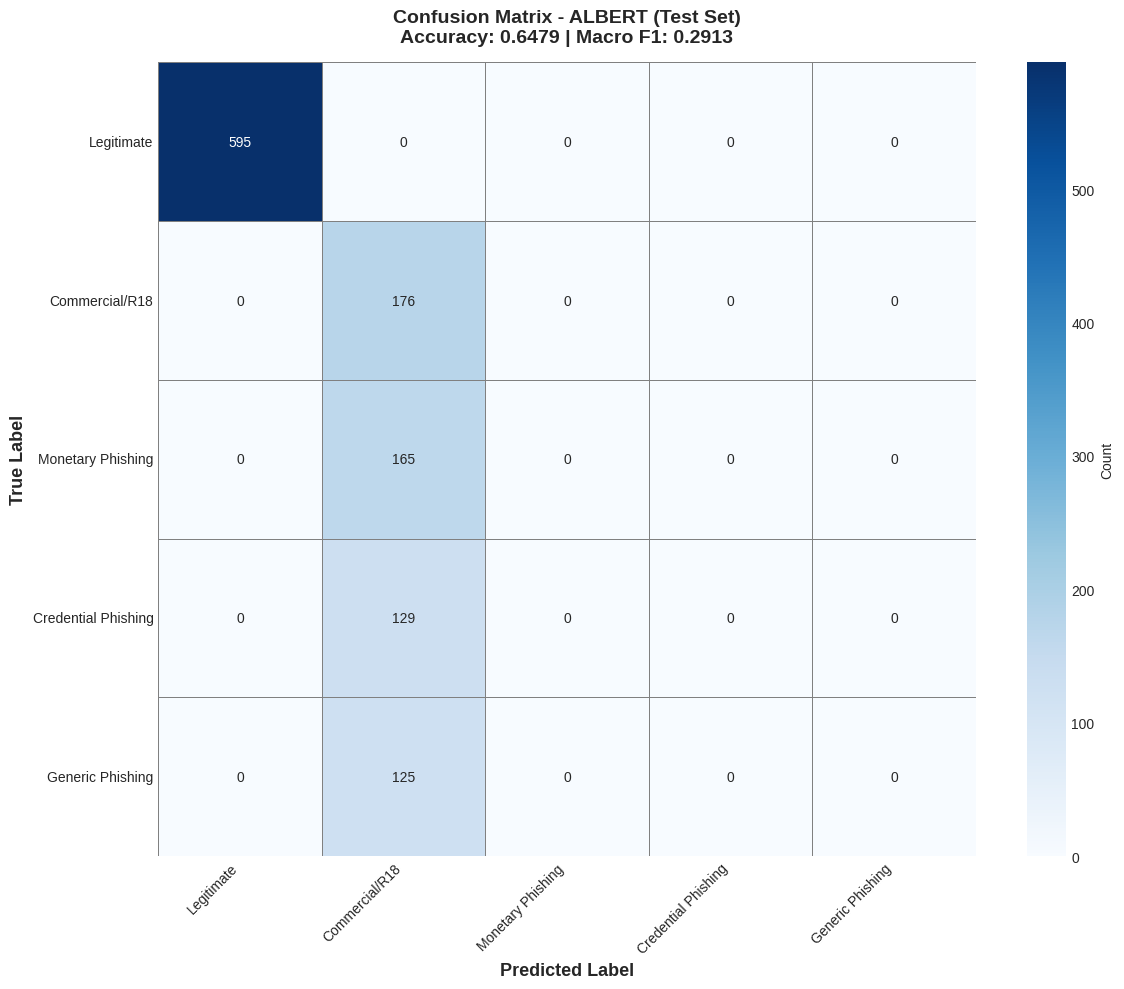


✓ Confusion matrix saved to: /content/drive/MyDrive/thesis_results/confusion_matrix_albert.png


In [18]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_LABELS.values(),
    yticklabels=CLASS_LABELS.values(),
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.title(f'Confusion Matrix - {best_model_name.upper()} (Test Set)\nAccuracy: {test_metrics["accuracy"]:.4f} | Macro F1: {test_metrics["macro_f1"]:.4f}',
          fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save
cm_path = f'{RESULTS_DIR}/confusion_matrix_{best_model_name}.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Confusion matrix saved to: {cm_path}")

## 14. Classification Report

In [19]:
print('\n' + '=' * 80)
print('DETAILED CLASSIFICATION REPORT')
print('=' * 80)
print()
print(classification_report(
    test_labels,
    test_preds,
    target_names=CLASS_LABELS.values(),
    digits=4
))
print('=' * 80)


DETAILED CLASSIFICATION REPORT

                     precision    recall  f1-score   support

         Legitimate     1.0000    1.0000    1.0000       595
     Commercial/R18     0.2958    1.0000    0.4565       176
  Monetary Phishing     0.0000    0.0000    0.0000       165
Credential Phishing     0.0000    0.0000    0.0000       129
   Generic Phishing     0.0000    0.0000    0.0000       125

           accuracy                         0.6479      1190
          macro avg     0.2592    0.4000    0.2913      1190
       weighted avg     0.5437    0.6479    0.5675      1190



## 15. Error Analysis

Examine misclassified examples to understand model limitations and inform future improvements.

In [20]:
print('\n' + '=' * 80)
print('ERROR ANALYSIS')
print('=' * 80)

# Find misclassified samples
errors = []
for i, (pred, true) in enumerate(zip(test_preds, test_labels)):
    if pred != true:
        errors.append({
            'index': i,
            'text': X_test[i],
            'true_label': CLASS_LABELS[true],
            'predicted_label': CLASS_LABELS[pred],
            'true_class': true,
            'pred_class': pred,
            'confidence': test_probs[i][pred],
            'true_prob': test_probs[i][true]
        })

print(f"\nMisclassifications: {len(errors)}/{len(test_labels)} ({len(errors)/len(test_labels)*100:.2f}%)")
print(f"Correct: {len(test_labels)-len(errors)}/{len(test_labels)} ({(len(test_labels)-len(errors))/len(test_labels)*100:.2f}%)")

# Error breakdown by true class
print(f"\n{'='*80}")
print('ERRORS BY TRUE CLASS')
print(f"{'='*80}")
print(f"{'True Class':<30} {'Errors':>10} {'Total':>10} {'Error Rate':>12}")
print('-' * 80)
for label in sorted(CLASS_LABELS.keys()):
    class_errors = [e for e in errors if e['true_class'] == label]
    class_total = (test_labels == label).sum()
    if class_total > 0:
        error_rate = len(class_errors) / class_total * 100
        print(f"{CLASS_LABELS[label]:<30} {len(class_errors):>10} {class_total:>10} {error_rate:>11.1f}%")
print('=' * 80)

# Most common confusion pairs
confusion_pairs = defaultdict(int)
for error in errors:
    pair = (error['true_label'], error['predicted_label'])
    confusion_pairs[pair] += 1

print(f"\n{'='*80}")
print('MOST COMMON CONFUSION PAIRS (Top 10)')
print(f"{'='*80}")
print(f"{'True Label':<25} {'→':>3} {'Predicted Label':<25} {'Count':>10}")
print('-' * 80)
for (true_label, pred_label), count in sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{true_label:<25} {'→':>3} {pred_label:<25} {count:>10}")
print('=' * 80)

# Show sample errors
print(f"\n{'='*80}")
print('SAMPLE MISCLASSIFIED EMAILS (First 10)')
print(f"{'='*80}")

for i, error in enumerate(errors[:10], 1):
    print(f"\nError #{i}:")
    print(f"  True Label:      {error['true_label']}")
    print(f"  Predicted Label: {error['predicted_label']}")
    print(f"  Confidence:      {error['confidence']:.3f} (pred) | {error['true_prob']:.3f} (true)")
    print(f"  Text (first 250 chars):")
    print(f"    {error['text'][:250]}...")
    print('-' * 80)

# Save full error analysis to CSV
error_df = pd.DataFrame(errors)
error_path = f"{RESULTS_DIR}/misclassified_samples.csv"
error_df.to_csv(error_path, index=False)
print(f"\n✓ Full error analysis saved to: {error_path}")
print(f"  ({len(errors)} misclassified samples with text, labels, and probabilities)")


ERROR ANALYSIS

Misclassifications: 419/1190 (35.21%)
Correct: 771/1190 (64.79%)

ERRORS BY TRUE CLASS
True Class                         Errors      Total   Error Rate
--------------------------------------------------------------------------------
Legitimate                              0        595         0.0%
Commercial/R18                          0        176         0.0%
Monetary Phishing                     165        165       100.0%
Credential Phishing                   129        129       100.0%
Generic Phishing                      125        125       100.0%

MOST COMMON CONFUSION PAIRS (Top 10)
True Label                  → Predicted Label                Count
--------------------------------------------------------------------------------
Monetary Phishing           → Commercial/R18                   165
Credential Phishing         → Commercial/R18                   129
Generic Phishing            → Commercial/R18                   125

SAMPLE MISCLASSIFIED EMAILS (Fi

## 16. Save Final Results and Summary

Package all results for thesis writing and analysis.

In [21]:
# Compile comprehensive results
final_results = {
    'timestamp': datetime.now().isoformat(),
    'config': CONFIG,

    'dataset_info': {
        'total_samples': len(full_df),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'class_distribution': {
            CLASS_LABELS[i]: int((full_df['label'] == i).sum())
            for i in sorted(CLASS_LABELS.keys())
        },
        'balancing_strategy': {
            'method': 'hybrid',
            'description': 'Undersample Commercial (30%), Oversample Credential (2x) & Generic (1.3x), Keep Monetary, Class-weighted loss',
            'targets': CONFIG['balance_targets']
        }
    },

    'cross_validation': {
        'n_folds': CONFIG['n_folds'],
        'results': cv_results_serializable
    },

    'best_model': {
        'name': best_model_name,
        'model_id': best_model_id,
        'cv_mean_f1': float(cv_results[best_model_name]['mean_f1']),
        'cv_std_f1': float(cv_results[best_model_name]['std_f1'])
    },

    'test_metrics': {
        k: float(v) if not k.startswith('per_class') else v.tolist()
        for k, v in test_metrics.items()
    },

    'per_class_results': {
        CLASS_LABELS[i]: {
            'precision': float(test_metrics['per_class_precision'][i]),
            'recall': float(test_metrics['per_class_recall'][i]),
            'f1_score': float(test_metrics['per_class_f1'][i]),
            'support': int((test_labels == i).sum())
        }
        for i in range(len(CLASS_LABELS))
    },

    'error_analysis': {
        'total_errors': len(errors),
        'error_rate': len(errors) / len(test_labels),
        'errors_by_class': {
            CLASS_LABELS[label]: len([e for e in errors if e['true_class'] == label])
            for label in CLASS_LABELS.keys()
        },
        'top_confusion_pairs': [
            {'true': true_label, 'predicted': pred_label, 'count': count}
            for (true_label, pred_label), count in sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)[:10]
        ]
    }
}

# Save to JSON
results_path = f"{RESULTS_DIR}/final_results.json"
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)

# Print summary
print('\n' + '=' * 80)
print('TRAINING COMPLETE - ALL RESULTS SAVED')
print('=' * 80)
print(f"\n📁 Results saved to Google Drive: {RESULTS_DIR}/")
print(f"\n  ✓ final_results.json - Comprehensive metrics and configuration")
print(f"  ✓ cv_results.json - Cross-validation fold scores")
print(f"  ✓ confusion_matrix_{best_model_name}.png - Confusion matrix visualization")
print(f"  ✓ misclassified_samples.csv - Error analysis with examples")
print(f"\n📁 Models saved to: {CHECKPOINT_DIR}/")
print(f"\n  ✓ {best_model_name}_best.pt - Best final model checkpoint")
print(f"  ✓ {best_model_name}_fold*_best.pt - CV fold checkpoints (5 files)")

print(f"\n{'='*80}")
print('FINAL TEST SET PERFORMANCE SUMMARY')
print(f"{'='*80}")
print(f"\nBest Model: {best_model_name.upper()}")
print(f"\nOverall Metrics:")
print(f"  Accuracy:     {test_metrics['accuracy']:.4f}")
print(f"  Macro F1:     {test_metrics['macro_f1']:.4f}")
print(f"  Weighted F1:  {test_metrics['weighted_f1']:.4f}")
print(f"  Cohen's Kappa: {test_metrics['cohen_kappa']:.4f}")
print(f"  AUC-ROC:      {test_metrics['auc_macro']:.4f}")

print(f"\nPer-Class F1 Scores:")
for i, class_name in CLASS_LABELS.items():
    print(f"  {class_name:<25}: {test_metrics['per_class_f1'][i]:.4f}")

print(f"\n{'='*80}")
print('\n🎉 Training pipeline complete!')
print('\nNext steps for thesis:')
print('  1. Analyze confusion matrix for class-specific patterns')
print('  2. Review error analysis CSV for failure modes')
print('  3. Compare with baseline models and other phishing studies')
print('  4. Prepare tables and figures from saved results')
print('=' * 80)


TRAINING COMPLETE - ALL RESULTS SAVED

📁 Results saved to Google Drive: /content/drive/MyDrive/thesis_results/

  ✓ final_results.json - Comprehensive metrics and configuration
  ✓ cv_results.json - Cross-validation fold scores
  ✓ confusion_matrix_albert.png - Confusion matrix visualization
  ✓ misclassified_samples.csv - Error analysis with examples

📁 Models saved to: /content/drive/MyDrive/thesis_checkpoints/

  ✓ albert_best.pt - Best final model checkpoint
  ✓ albert_fold*_best.pt - CV fold checkpoints (5 files)

FINAL TEST SET PERFORMANCE SUMMARY

Best Model: ALBERT

Overall Metrics:
  Accuracy:     0.6479
  Macro F1:     0.2913
  Weighted F1:  0.5675
  Cohen's Kappa: 0.4792
  AUC-ROC:      0.8287

Per-Class F1 Scores:
  Legitimate               : 1.0000
  Commercial/R18           : 0.4565
  Monetary Phishing        : 0.0000
  Credential Phishing      : 0.0000
  Generic Phishing         : 0.0000


🎉 Training pipeline complete!

Next steps for thesis:
  1. Analyze confusion matr

## 17. Comprehensive Visualizations and Model Analysis

This section provides publication-ready visualizations and numerical tables for thesis documentation.

### Overview:
- **17.1**: Model Comparison (CV performance across all models)
- **17.2**: Training Dynamics (learning curves for best model)
- **17.3**: Per-Class Analysis (which phishing types are hardest?)
- **17.4**: ROC and Precision-Recall Curves (threshold analysis)
- **17.5**: Data Distribution Analysis (balancing impact)

All visualizations are saved to Google Drive for inclusion in thesis.

### 17.1 Model Comparison

Compare all three models (ALBERT, DistilBERT, RoBERTa) on cross-validation performance.


17.1 MODEL COMPARISON


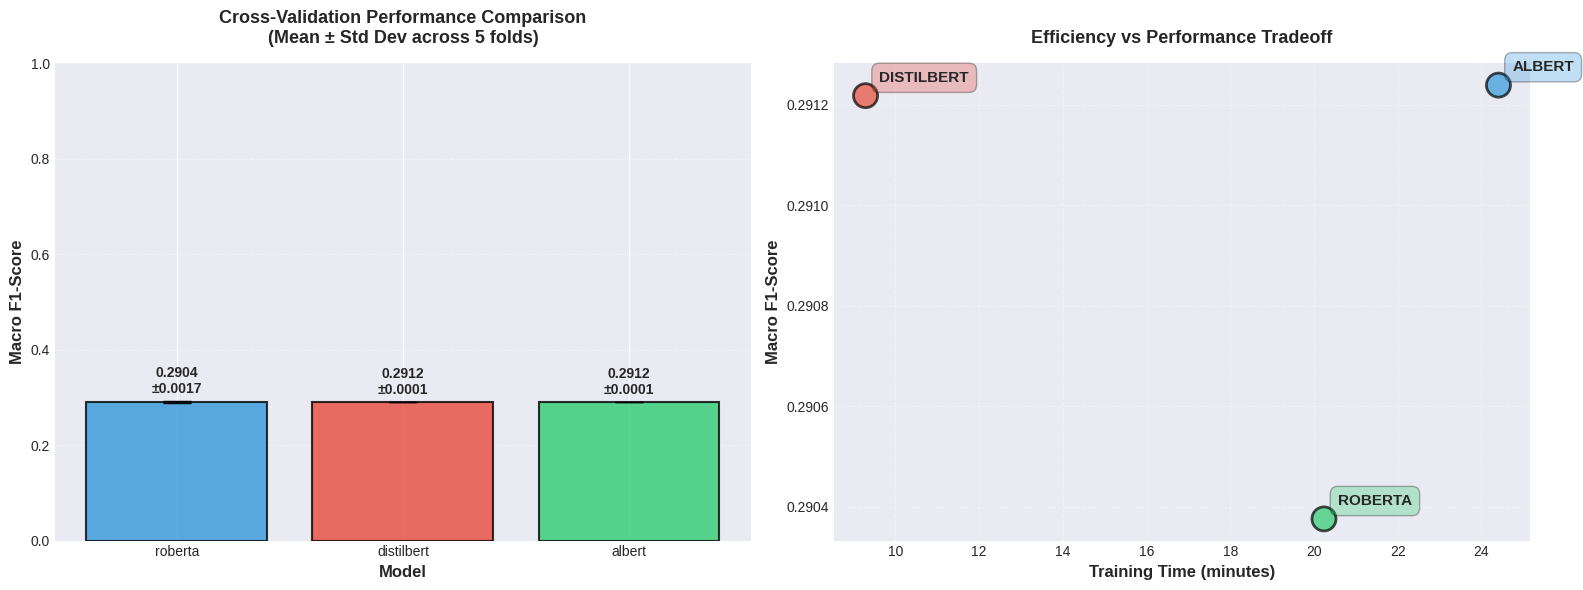


✓ Figure saved: /content/drive/MyDrive/thesis_results/model_comparison_cv.png

TABLE 1: Cross-Validation Results Summary

Model                Mean F1      Std Dev   Time (min)    Best Fold   Worst Fold
--------------------------------------------------------------------------------
albert                0.2912       0.0001         24.4       0.2915       0.2912
distilbert            0.2912       0.0001          9.3       0.2915       0.2911
roberta               0.2904       0.0017         20.2       0.2915       0.2869

TABLE 2: Individual Fold Scores

Model               Fold 1     Fold 2     Fold 3     Fold 4     Fold 5
--------------------------------------------------------------------------------
albert              0.2912     0.2912     0.2915     0.2912     0.2912 
distilbert          0.2911     0.2912     0.2915     0.2912     0.2912 
roberta             0.2912     0.2869     0.2915     0.2912     0.2912 


In [22]:
print('\n' + '=' * 80)
print('17.1 MODEL COMPARISON')
print('=' * 80)

# Prepare data for plotting
model_names = list(cv_results.keys())
mean_f1s = [cv_results[m]['mean_f1'] for m in model_names]
std_f1s = [cv_results[m]['std_f1'] for m in model_names]
training_times = [cv_results[m]['training_time']/60 for m in model_names]  # Convert to minutes

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: CV Performance Comparison with error bars
ax1 = axes[0]
bars = ax1.bar(model_names, mean_f1s, yerr=std_f1s, capsize=10,
               color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Macro F1-Score', fontsize=12, fontweight='bold')
ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_title('Cross-Validation Performance Comparison\n(Mean ± Std Dev across 5 folds)',
              fontsize=13, fontweight='bold', pad=15)
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, mean_f1s, std_f1s)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
             f'{mean:.4f}\n±{std:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Training Time vs Performance
ax2 = axes[1]
colors_map = {'albert': '#3498db', 'distilbert': '#e74c3c', 'roberta': '#2ecc71'}
colors = [colors_map.get(m, '#95a5a6') for m in model_names]

scatter = ax2.scatter(training_times, mean_f1s, s=300, c=colors, alpha=0.7,
                     edgecolors='black', linewidth=2)
ax2.set_xlabel('Training Time (minutes)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Macro F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('Efficiency vs Performance Tradeoff', fontsize=13, fontweight='bold', pad=15)
ax2.grid(alpha=0.3, linestyle='--')

# Add model labels
for i, (name, time, f1) in enumerate(zip(model_names, training_times, mean_f1s)):
    ax2.annotate(name.upper(), (time, f1),
                xytext=(10, 10), textcoords='offset points',
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.3))

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/model_comparison_cv.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {RESULTS_DIR}/model_comparison_cv.png")

# Numerical Table: Complete CV Results
print('\n' + '=' * 80)
print('TABLE 1: Cross-Validation Results Summary')
print('=' * 80)
print(f"\n{'Model':<15} {'Mean F1':>12} {'Std Dev':>12} {'Time (min)':>12} {'Best Fold':>12} {'Worst Fold':>12}")
print('-' * 80)
for model_name in sorted(cv_results.keys(), key=lambda x: cv_results[x]['mean_f1'], reverse=True):
    result = cv_results[model_name]
    best_fold = max(result['fold_scores'])
    worst_fold = min(result['fold_scores'])
    print(f"{model_name:<15} {result['mean_f1']:>12.4f} {result['std_f1']:>12.4f} "
          f"{result['training_time']/60:>12.1f} {best_fold:>12.4f} {worst_fold:>12.4f}")
print('=' * 80)

# Individual fold scores table
print('\n' + '=' * 80)
print('TABLE 2: Individual Fold Scores')
print('=' * 80)
print(f"\n{'Model':<15} {'Fold 1':>10} {'Fold 2':>10} {'Fold 3':>10} {'Fold 4':>10} {'Fold 5':>10}")
print('-' * 80)
for model_name in sorted(cv_results.keys()):
    scores = cv_results[model_name]['fold_scores']
    print(f"{model_name:<15} ", end='')
    for score in scores:
        print(f"{score:>10.4f} ", end='')
    print()
print('=' * 80)

### 17.2 Training Dynamics (Best Model)

Analyze how the best model learned over epochs: loss curves, accuracy progression, and early stopping behavior.


17.2 TRAINING DYNAMICS (BEST MODEL)


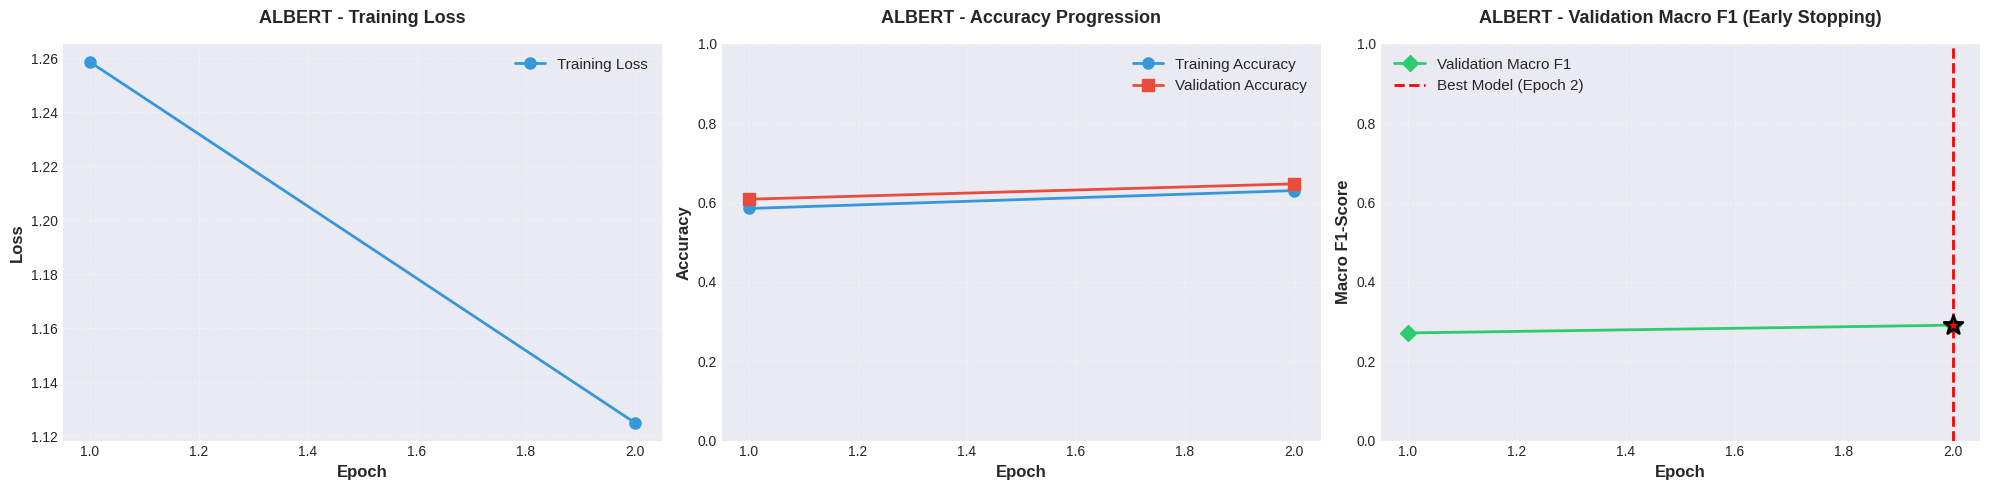


✓ Figure saved: /content/drive/MyDrive/thesis_results/training_dynamics_albert.png

TABLE 3: Epoch-by-Epoch Training Metrics (ALBERT)

  Epoch   Train Loss    Train Acc      Val Acc   Val Macro F1                Notes
--------------------------------------------------------------------------------
      1       1.2587       0.5850       0.6084         0.2713                     
      2       1.1251       0.6301       0.6471         0.2909         ← BEST MODEL

Early Stopping Analysis
Best epoch: 2/10
Best validation Macro F1: 0.2909
Total epochs trained: 2
Early stopping triggered: YES (saved 8 epoch(s))


In [26]:
print('\n' + '=' * 80)
print('17.2 TRAINING DYNAMICS (BEST MODEL)')
print('=' * 80)

# Extract training history from checkpoint
checkpoint_path = f"{CHECKPOINT_DIR}/{best_model_name}_best.pt"
# FIX: Set weights_only=False to allow loading history dict
checkpoint = torch.load(checkpoint_path, weights_only=False)
history = checkpoint['history']

epochs_trained = len(history['train_loss'])
epochs_range = range(1, epochs_trained + 1)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: Loss Curves
ax1 = axes[0]
ax1.plot(epochs_range, history['train_loss'], 'o-', linewidth=2,
         markersize=8, label='Training Loss', color='#3498db')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title(f'{best_model_name.upper()} - Training Loss',
              fontsize=13, fontweight='bold', pad=15)
ax1.grid(alpha=0.3, linestyle='--')
ax1.legend(fontsize=11)

# Plot 2: Accuracy Curves
ax2 = axes[1]
ax2.plot(epochs_range, history['train_acc'], 'o-', linewidth=2,
         markersize=8, label='Training Accuracy', color='#3498db')
ax2.plot(epochs_range, history['val_acc'], 's-', linewidth=2,
         markersize=8, label='Validation Accuracy', color='#e74c3c')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title(f'{best_model_name.upper()} - Accuracy Progression',
              fontsize=13, fontweight='bold', pad=15)
ax2.set_ylim([0, 1.0])
ax2.grid(alpha=0.3, linestyle='--')
ax2.legend(fontsize=11)

# Plot 3: Validation Macro F1 with Early Stopping
ax3 = axes[2]
ax3.plot(epochs_range, history['val_macro_f1'], 'D-', linewidth=2,
         markersize=8, label='Validation Macro F1', color='#2ecc71')

# Mark best epoch
best_epoch = checkpoint['epoch'] + 1
best_f1_val = checkpoint['best_f1']
ax3.axvline(x=best_epoch, color='red', linestyle='--', linewidth=2,
            label=f'Best Model (Epoch {best_epoch})')
ax3.scatter([best_epoch], [best_f1_val], s=200, c='red', marker='*',
            edgecolors='black', linewidth=2, zorder=5)

ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Macro F1-Score', fontsize=12, fontweight='bold')
ax3.set_title(f'{best_model_name.upper()} - Validation Macro F1 (Early Stopping)',
              fontsize=13, fontweight='bold', pad=15)
ax3.set_ylim([0, 1.0])
ax3.grid(alpha=0.3, linestyle='--')
ax3.legend(fontsize=11)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/training_dynamics_{best_model_name}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {RESULTS_DIR}/training_dynamics_{best_model_name}.png")

# Numerical Table: Epoch-by-Epoch Metrics
print('\n' + '=' * 80)
print(f'TABLE 3: Epoch-by-Epoch Training Metrics ({best_model_name.upper()})')
print('=' * 80)
print(f"\n{'Epoch':>7} {'Train Loss':>12} {'Train Acc':>12} {'Val Acc':>12} {'Val Macro F1':>14} {'Notes':>20}")
print('-' * 80)
for epoch in range(epochs_trained):
    notes = ''
    if epoch == checkpoint['epoch']:
        notes = '← BEST MODEL'
    print(f"{epoch+1:>7} {history['train_loss'][epoch]:>12.4f} "
          f"{history['train_acc'][epoch]:>12.4f} {history['val_acc'][epoch]:>12.4f} "
          f"{history['val_macro_f1'][epoch]:>14.4f} {notes:>20}")
print('=' * 80)

# Early stopping analysis
print('\n' + '=' * 80)
print('Early Stopping Analysis')
print('=' * 80)
print(f"Best epoch: {best_epoch}/{CONFIG['epochs']}")
print(f"Best validation Macro F1: {best_f1_val:.4f}")
print(f"Total epochs trained: {epochs_trained}")
if epochs_trained < CONFIG['epochs']:
    print(f"Early stopping triggered: YES (saved {CONFIG['epochs'] - epochs_trained} epoch(s))")
else:
    print(f"Early stopping triggered: NO (trained full {CONFIG['epochs']} epochs)")
print('=' * 80)

### 17.3 Per-Class Analysis

Examine which phishing types are easiest/hardest to detect. This guides future research directions.


17.3 PER-CLASS ANALYSIS


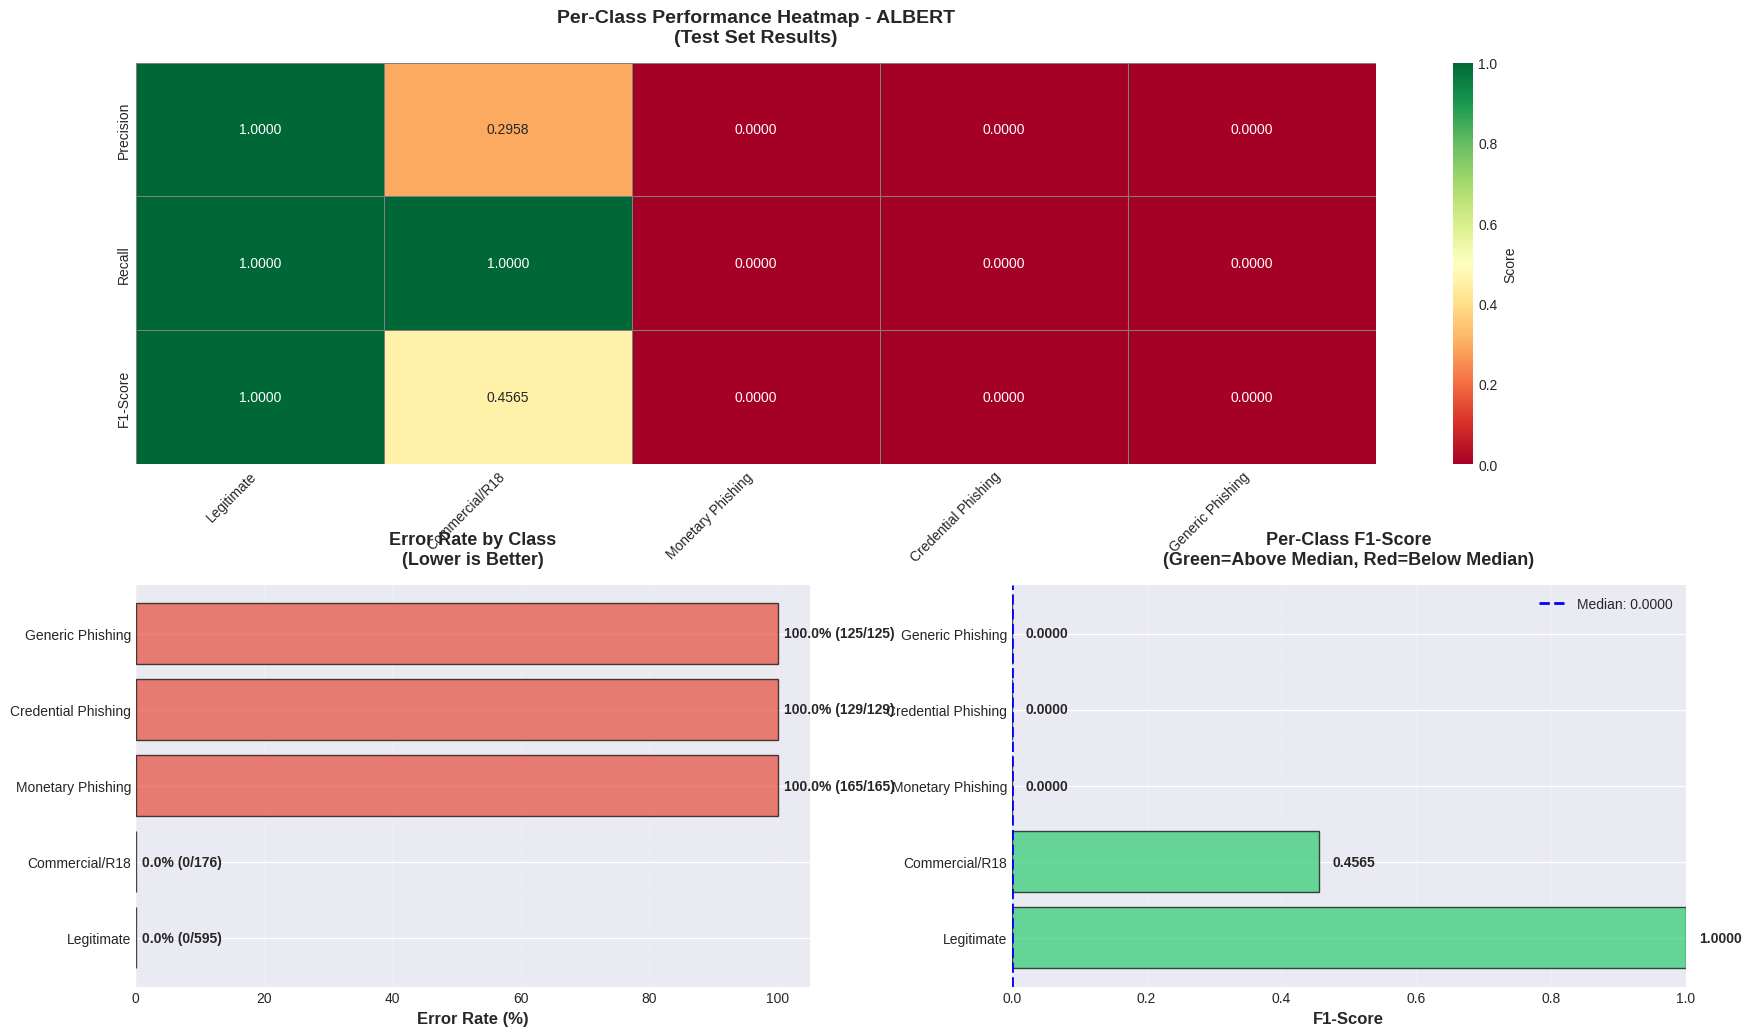


✓ Figure saved: /content/drive/MyDrive/thesis_results/per_class_analysis.png

TABLE 4: Detailed Per-Class Performance

  Class Label                       Precision      Recall    F1-Score   Support    Errors
----------------------------------------------------------------------------------------------------
      0 Legitimate                     1.0000      1.0000      1.0000       595         0
      1 Commercial/R18                 0.2958      1.0000      0.4565       176         0
      2 Monetary Phishing              0.0000      0.0000      0.0000       165       165
      3 Credential Phishing            0.0000      0.0000      0.0000       129       129
      4 Generic Phishing               0.0000      0.0000      0.0000       125       125
----------------------------------------------------------------------------------------------------
AVG     Macro Average                  0.2592      0.4000      0.2913      1190       419

CLASS DIFFICULTY RANKING (by F1-Score)

  Rank 

In [24]:
print('\n' + '=' * 80)
print('17.3 PER-CLASS ANALYSIS')
print('=' * 80)

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Plot 1: Per-Class Performance Heatmap
ax1 = fig.add_subplot(gs[0, :])

# Prepare data for heatmap
class_names = [CLASS_LABELS[i] for i in range(len(CLASS_LABELS))]
metrics_data = np.array([
    test_metrics['per_class_precision'],
    test_metrics['per_class_recall'],
    test_metrics['per_class_f1']
])

# Create heatmap
sns.heatmap(metrics_data, annot=True, fmt='.4f', cmap='RdYlGn', vmin=0, vmax=1,
            xticklabels=class_names, yticklabels=['Precision', 'Recall', 'F1-Score'],
            cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='gray', ax=ax1)
ax1.set_title(f'Per-Class Performance Heatmap - {best_model_name.upper()}\n(Test Set Results)',
              fontsize=14, fontweight='bold', pad=15)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Plot 2: Error Rate by Class
ax2 = fig.add_subplot(gs[1, 0])

class_totals = [(test_labels == i).sum() for i in range(len(CLASS_LABELS))]
class_errors = [len([e for e in errors if e['true_class'] == i]) for i in range(len(CLASS_LABELS))]
error_rates = [err/total*100 if total > 0 else 0 for err, total in zip(class_errors, class_totals)]

bars = ax2.barh(class_names, error_rates, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Error Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Error Rate by Class\n(Lower is Better)', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, rate, err, tot) in enumerate(zip(bars, error_rates, class_errors, class_totals)):
    width = bar.get_width()
    ax2.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{rate:.1f}% ({err}/{tot})',
             va='center', fontsize=10, fontweight='bold')

# Plot 3: F1-Score Comparison (Best vs Worst Classes)
ax3 = fig.add_subplot(gs[1, 1])

f1_scores = test_metrics['per_class_f1']
colors_f1 = ['#2ecc71' if f1 >= np.median(f1_scores) else '#e74c3c' for f1 in f1_scores]

bars = ax3.barh(class_names, f1_scores, color=colors_f1, alpha=0.7, edgecolor='black')
ax3.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax3.set_title('Per-Class F1-Score\n(Green=Above Median, Red=Below Median)',
              fontsize=13, fontweight='bold', pad=15)
ax3.set_xlim([0, 1.0])
ax3.grid(axis='x', alpha=0.3, linestyle='--')

# Add median line
median_f1 = np.median(f1_scores)
ax3.axvline(x=median_f1, color='blue', linestyle='--', linewidth=2,
            label=f'Median: {median_f1:.4f}')
ax3.legend(fontsize=10)

# Add value labels
for bar, f1 in zip(bars, f1_scores):
    width = bar.get_width()
    ax3.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f'{f1:.4f}',
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/per_class_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {RESULTS_DIR}/per_class_analysis.png")

# Numerical Table: Detailed Per-Class Metrics
print('\n' + '=' * 80)
print('TABLE 4: Detailed Per-Class Performance')
print('=' * 80)
print(f"\n{'Class':>7} {'Label':<25} {'Precision':>11} {'Recall':>11} {'F1-Score':>11} "
      f"{'Support':>9} {'Errors':>9}")
print('-' * 100)
for i in range(len(CLASS_LABELS)):
    print(f"{i:>7} {CLASS_LABELS[i]:<25} "
          f"{test_metrics['per_class_precision'][i]:>11.4f} "
          f"{test_metrics['per_class_recall'][i]:>11.4f} "
          f"{test_metrics['per_class_f1'][i]:>11.4f} "
          f"{class_totals[i]:>9} {class_errors[i]:>9}")
print('-' * 100)
print(f"{'AVG':<7} {'Macro Average':<25} "
      f"{test_metrics['macro_precision']:>11.4f} "
      f"{test_metrics['macro_recall']:>11.4f} "
      f"{test_metrics['macro_f1']:>11.4f} "
      f"{sum(class_totals):>9} {len(errors):>9}")
print('=' * 100)

# Identify hardest/easiest classes
print('\n' + '=' * 80)
print('CLASS DIFFICULTY RANKING (by F1-Score)')
print('=' * 80)
sorted_classes = sorted(range(len(CLASS_LABELS)),
                       key=lambda i: test_metrics['per_class_f1'][i],
                       reverse=True)
print(f"\n{'Rank':>6} {'Class':<30} {'F1-Score':>12} {'Difficulty':>15}")
print('-' * 70)
for rank, cls_idx in enumerate(sorted_classes, 1):
    f1 = test_metrics['per_class_f1'][cls_idx]
    if rank == 1:
        difficulty = '⭐ EASIEST'
    elif rank == len(sorted_classes):
        difficulty = '⚠️  HARDEST'
    else:
        difficulty = 'Medium'
    print(f"{rank:>6} {CLASS_LABELS[cls_idx]:<30} {f1:>12.4f} {difficulty:>15}")
print('=' * 70)

# Research implications
hardest_class_idx = sorted_classes[-1]
hardest_class = CLASS_LABELS[hardest_class_idx]
hardest_f1 = test_metrics['per_class_f1'][hardest_class_idx]

print('\n' + '=' * 80)
print('RESEARCH IMPLICATIONS')
print('=' * 80)
print(f"\nHardest Class to Detect: {hardest_class} (F1 = {hardest_f1:.4f})")
print(f"\nSuggested Future Work:")
print(f"  1. Collect more training examples for {hardest_class}")
print(f"  2. Analyze linguistic features specific to {hardest_class}")
print(f"  3. Consider ensemble methods or specialized models for this class")
print(f"  4. Investigate if {hardest_class} has overlapping characteristics with other classes")
print('=' * 80)

### 17.4 ROC and Precision-Recall Curves

Analyze classification performance at different thresholds using ROC (Receiver Operating Characteristic) and PR (Precision-Recall) curves.


17.4 ROC AND PRECISION-RECALL CURVES


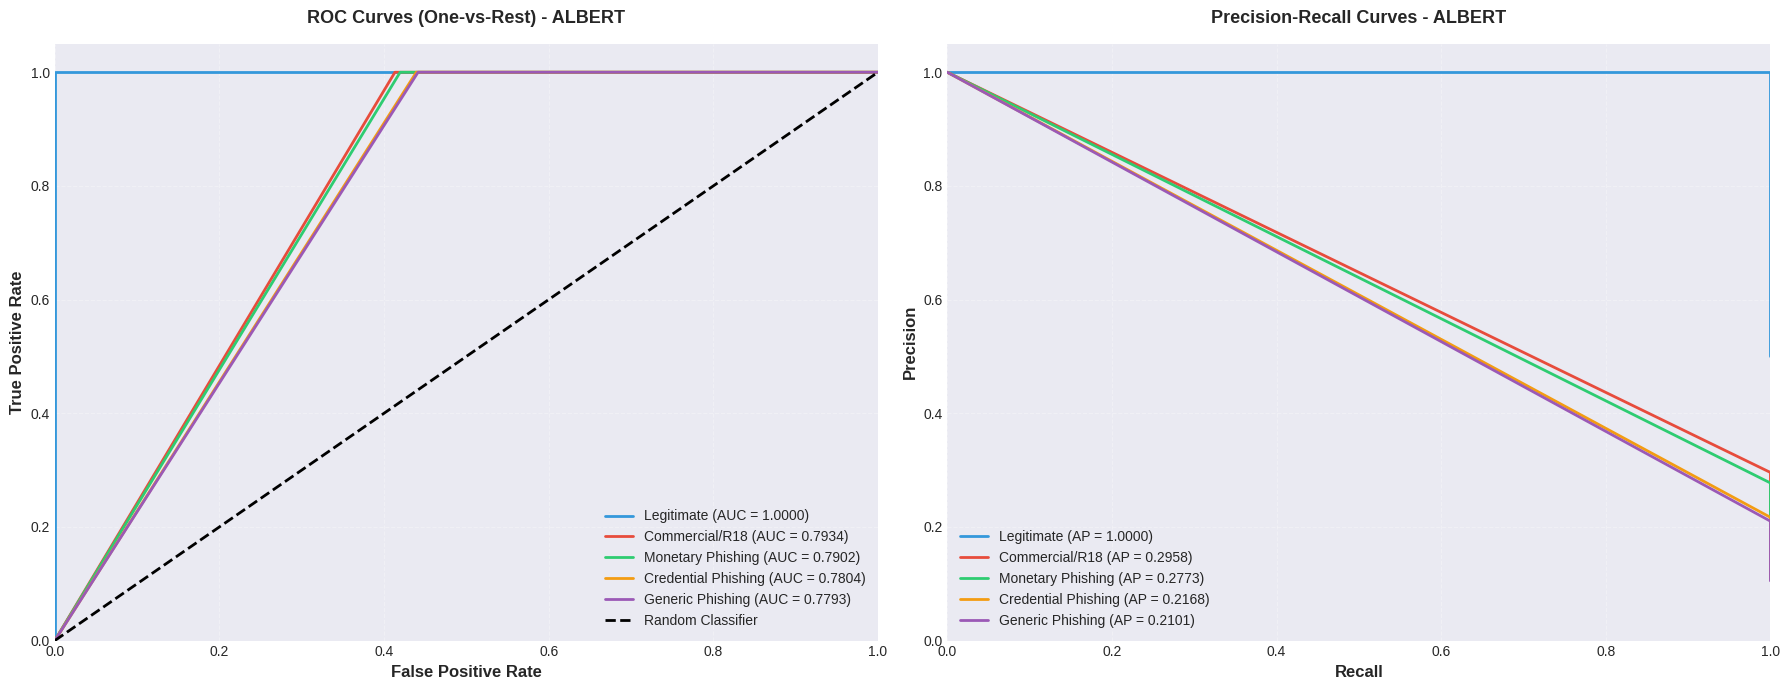


✓ Figure saved: /content/drive/MyDrive/thesis_results/roc_pr_curves.png

TABLE 5: ROC-AUC and Average Precision Scores

  Class Label                          ROC-AUC   Avg Precision     F1-Score
--------------------------------------------------------------------------------
      0 Legitimate                      1.0000          1.0000       1.0000
      1 Commercial/R18                  0.7934          0.2958       0.4565
      2 Monetary Phishing               0.7902          0.2773       0.0000
      3 Credential Phishing             0.7804          0.2168       0.0000
      4 Generic Phishing                0.7793          0.2101       0.0000
--------------------------------------------------------------------------------
AVG     Macro Average                   0.8287          0.4000       0.2913

Interpretation:
  - ROC-AUC: Overall discriminative ability (higher = better separation)
  - Avg Precision: Performance across all thresholds (higher = better for imbalanced)
  - F1-Sc

In [25]:
print('\n' + '=' * 80)
print('17.4 ROC AND PRECISION-RECALL CURVES')
print('=' * 80)

from sklearn.metrics import precision_recall_curve, average_precision_score, auc

# Binarize labels for one-vs-rest
y_test_bin = label_binarize(test_labels, classes=list(range(len(CLASS_LABELS))))

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Define colors for each class
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

# Plot 1: ROC Curves (One-vs-Rest)
ax1 = axes[0]

roc_auc_scores = {}
for i, color in enumerate(colors[:len(CLASS_LABELS)]):
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[i] = roc_auc

    # Plot
    ax1.plot(fpr, tpr, color=color, linewidth=2,
             label=f'{CLASS_LABELS[i]} (AUC = {roc_auc:.4f})')

# Plot diagonal (random classifier)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title(f'ROC Curves (One-vs-Rest) - {best_model_name.upper()}',
              fontsize=13, fontweight='bold', pad=15)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])

# Plot 2: Precision-Recall Curves
ax2 = axes[1]

ap_scores = {}
for i, color in enumerate(colors[:len(CLASS_LABELS)]):
    # Compute PR curve
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], test_probs[:, i])
    ap = average_precision_score(y_test_bin[:, i], test_probs[:, i])
    ap_scores[i] = ap

    # Plot
    ax2.plot(recall, precision, color=color, linewidth=2,
             label=f'{CLASS_LABELS[i]} (AP = {ap:.4f})')

ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax2.set_title(f'Precision-Recall Curves - {best_model_name.upper()}',
              fontsize=13, fontweight='bold', pad=15)
ax2.legend(loc='lower left', fontsize=10)
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {RESULTS_DIR}/roc_pr_curves.png")

# Numerical Tables
print('\n' + '=' * 80)
print('TABLE 5: ROC-AUC and Average Precision Scores')
print('=' * 80)
print(f"\n{'Class':>7} {'Label':<25} {'ROC-AUC':>12} {'Avg Precision':>15} {'F1-Score':>12}")
print('-' * 80)
for i in range(len(CLASS_LABELS)):
    print(f"{i:>7} {CLASS_LABELS[i]:<25} {roc_auc_scores[i]:>12.4f} "
          f"{ap_scores[i]:>15.4f} {test_metrics['per_class_f1'][i]:>12.4f}")
print('-' * 80)
print(f"{'AVG':<7} {'Macro Average':<25} "
      f"{np.mean(list(roc_auc_scores.values())):>12.4f} "
      f"{np.mean(list(ap_scores.values())):>15.4f} "
      f"{test_metrics['macro_f1']:>12.4f}")
print('=' * 80)

print('\nInterpretation:')
print('  - ROC-AUC: Overall discriminative ability (higher = better separation)')
print('  - Avg Precision: Performance across all thresholds (higher = better for imbalanced)')
print('  - F1-Score: Balance of precision and recall at optimal threshold')
print('=' * 80)

### 17.5 Data Distribution Analysis

Visualize the impact of hybrid balancing strategy on class distribution and analyze dataset characteristics.


17.5 DATA DISTRIBUTION ANALYSIS


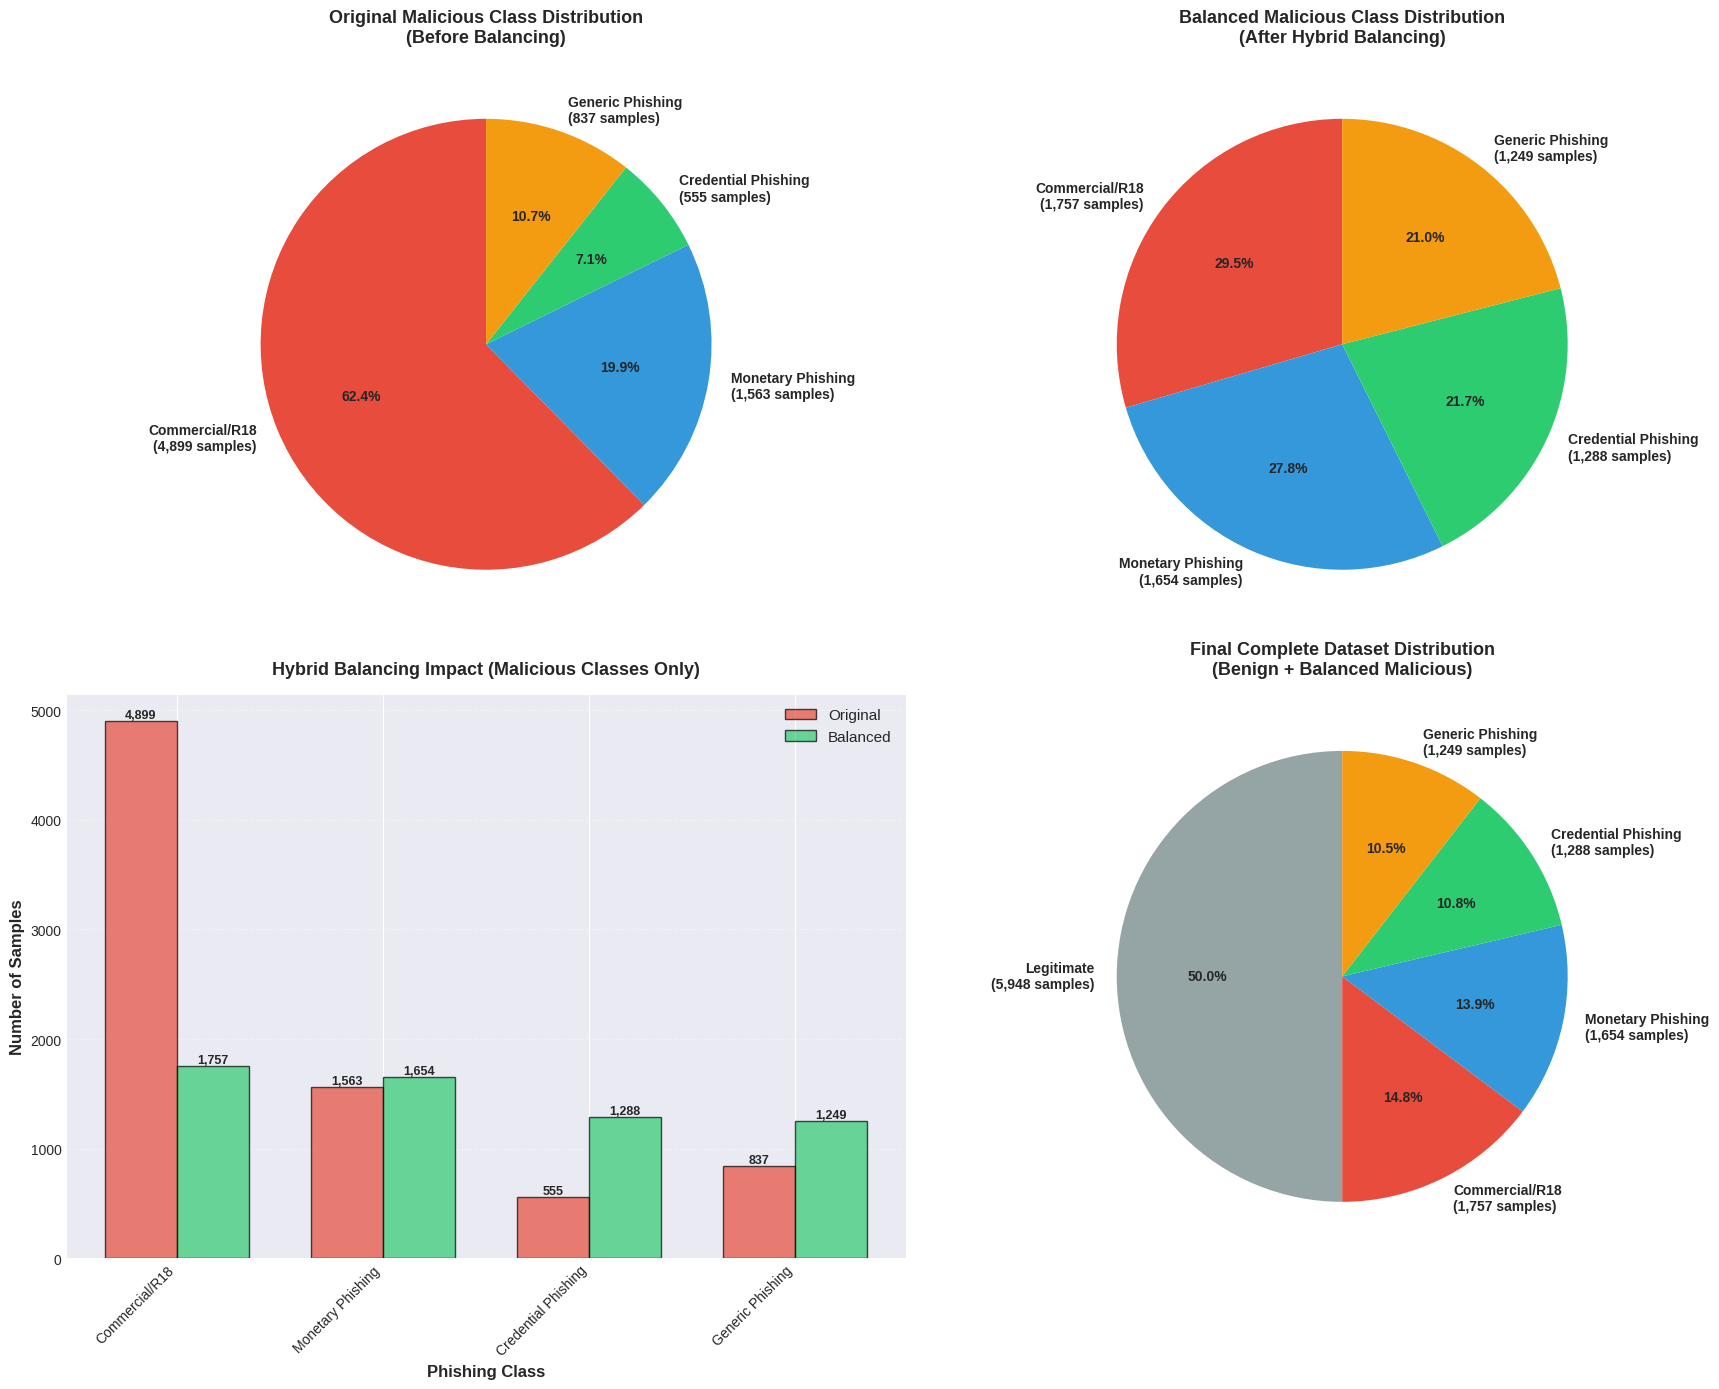


✓ Figure saved: /content/drive/MyDrive/thesis_results/data_distribution_analysis.png

TABLE 6: Hybrid Balancing Strategy Impact

Class                              Original     Balanced       Change               Method
------------------------------------------------------------------------------------------
Commercial/R18                        4,899        1,757       -3,142   Undersample (0.4x)
Monetary Phishing                     1,563        1,654          +91    Oversample (1.1x)
Credential Phishing                     555        1,288         +733    Oversample (2.3x)
Generic Phishing                        837        1,249         +412    Oversample (1.5x)
------------------------------------------------------------------------------------------
TOTAL MALICIOUS                       7,854        5,948       -1,906

TABLE 7: Complete Dataset Statistics

Split                       Total       Benign    Malicious        Ratio
---------------------------------------------------

In [27]:
print('\n' + '=' * 80)
print('17.5 DATA DISTRIBUTION ANALYSIS')
print('=' * 80)

# Note: We need to reconstruct original distribution from memory
# Since we don't have the original unbalanced data in variables anymore
# We'll document the transformation that occurred

# Original malicious distribution (from thesis data)
original_malicious = {
    'Commercial/R18': 4899,
    'Monetary Phishing': 1563,
    'Credential Phishing': 555,
    'Generic Phishing': 837
}

# Balanced malicious distribution (from CONFIG)
balanced_malicious = {
    'Commercial/R18': CONFIG['balance_targets'][1],
    'Monetary Phishing': CONFIG['balance_targets'][2],
    'Credential Phishing': CONFIG['balance_targets'][3],
    'Generic Phishing': CONFIG['balance_targets'][4]
}

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Original Malicious Distribution (Pie Chart)
ax1 = axes[0, 0]
colors_pie = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
wedges, texts, autotexts = ax1.pie(
    original_malicious.values(),
    labels=original_malicious.keys(),
    autopct='%1.1f%%',
    colors=colors_pie,
    startangle=90,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)
ax1.set_title('Original Malicious Class Distribution\n(Before Balancing)',
              fontsize=13, fontweight='bold', pad=15)

# Add sample counts
for i, (text, count) in enumerate(zip(texts, original_malicious.values())):
    text.set_text(f"{text.get_text()}\n({count:,} samples)")

# Plot 2: Balanced Malicious Distribution (Pie Chart)
ax2 = axes[0, 1]
wedges2, texts2, autotexts2 = ax2.pie(
    balanced_malicious.values(),
    labels=balanced_malicious.keys(),
    autopct='%1.1f%%',
    colors=colors_pie,
    startangle=90,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)
ax2.set_title('Balanced Malicious Class Distribution\n(After Hybrid Balancing)',
              fontsize=13, fontweight='bold', pad=15)

for i, (text, count) in enumerate(zip(texts2, balanced_malicious.values())):
    text.set_text(f"{text.get_text()}\n({count:,} samples)")

# Plot 3: Before/After Comparison (Bar Chart)
ax3 = axes[1, 0]

classes = list(original_malicious.keys())
original_counts = list(original_malicious.values())
balanced_counts = list(balanced_malicious.values())

x = np.arange(len(classes))
width = 0.35

bars1 = ax3.bar(x - width/2, original_counts, width, label='Original',
                color='#e74c3c', alpha=0.7, edgecolor='black')
bars2 = ax3.bar(x + width/2, balanced_counts, width, label='Balanced',
                color='#2ecc71', alpha=0.7, edgecolor='black')

ax3.set_xlabel('Phishing Class', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax3.set_title('Hybrid Balancing Impact (Malicious Classes Only)',
              fontsize=13, fontweight='bold', pad=15)
ax3.set_xticks(x)
ax3.set_xticklabels(classes, rotation=45, ha='right')
ax3.legend(fontsize=11)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 4: Final Complete Dataset Distribution
ax4 = axes[1, 1]

final_dist = {}
for label in sorted(full_df['label'].unique()):
    count = (full_df['label'] == label).sum()
    final_dist[CLASS_LABELS[int(label)]] = count

colors_final = ['#95a5a6', '#e74c3c', '#3498db', '#2ecc71', '#f39c12']
wedges3, texts3, autotexts3 = ax4.pie(
    final_dist.values(),
    labels=final_dist.keys(),
    autopct='%1.1f%%',
    colors=colors_final,
    startangle=90,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)
ax4.set_title('Final Complete Dataset Distribution\n(Benign + Balanced Malicious)',
              fontsize=13, fontweight='bold', pad=15)

for i, (text, count) in enumerate(zip(texts3, final_dist.values())):
    text.set_text(f"{text.get_text()}\n({count:,} samples)")

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/data_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {RESULTS_DIR}/data_distribution_analysis.png")

# Numerical Tables
print('\n' + '=' * 80)
print('TABLE 6: Hybrid Balancing Strategy Impact')
print('=' * 80)
print(f"\n{'Class':<30} {'Original':>12} {'Balanced':>12} {'Change':>12} {'Method':>20}")
print('-' * 90)
for class_name in original_malicious.keys():
    orig = original_malicious[class_name]
    bal = balanced_malicious[class_name]
    change = bal - orig
    pct_change = (change / orig * 100) if orig > 0 else 0

    if change > 0:
        method = f"Oversample ({bal/orig:.1f}x)"
    elif change < 0:
        method = f"Undersample ({bal/orig:.1f}x)"
    else:
        method = "Keep all"

    print(f"{class_name:<30} {orig:>12,} {bal:>12,} {change:>+12,} {method:>20}")
print('-' * 90)
print(f"{'TOTAL MALICIOUS':<30} {sum(original_malicious.values()):>12,} "
      f"{sum(balanced_malicious.values()):>12,} "
      f"{sum(balanced_malicious.values())-sum(original_malicious.values()):>+12,}")
print('=' * 90)

print('\n' + '=' * 80)
print('TABLE 7: Complete Dataset Statistics')
print('=' * 80)
print(f"\n{'Split':<20} {'Total':>12} {'Benign':>12} {'Malicious':>12} {'Ratio':>12}")
print('-' * 70)
print(f"{'Original Data':<20} {len(full_df):>12,} "
      f"{(full_df['label']==0).sum():>12,} "
      f"{(full_df['label']!=0).sum():>12,} "
      f"{(full_df['label']==0).sum()/(full_df['label']!=0).sum():.2f}:1")
print(f"{'Training Set':<20} {len(X_train):>12,} "
      f"{(y_train==0).sum():>12,} "
      f"{(y_train!=0).sum():>12,} "
      f"{(y_train==0).sum()/(y_train!=0).sum():.2f}:1")
print(f"{'Validation Set':<20} {len(X_val):>12,} "
      f"{(y_val==0).sum():>12,} "
      f"{(y_val!=0).sum():>12,} "
      f"{(y_val==0).sum()/(y_val!=0).sum():.2f}:1")
print(f"{'Test Set':<20} {len(X_test):>12,} "
      f"{(y_test==0).sum():>12,} "
      f"{(y_test!=0).sum():>12,} "
      f"{(y_test==0).sum()/(y_test!=0).sum():.2f}:1")
print('=' * 70)

## 18. Visualization Summary

All visualizations and numerical tables have been generated and saved to Google Drive.

### Files Saved:
1. **model_comparison_cv.png** - Cross-validation performance and efficiency comparison
2. **training_dynamics_[model].png** - Learning curves and early stopping analysis
3. **per_class_analysis.png** - Per-class performance heatmap and error analysis
4. **roc_pr_curves.png** - ROC and Precision-Recall curves for all classes
5. **data_distribution_analysis.png** - Balancing strategy impact visualization
6. **confusion_matrix_[model].png** - Final test set confusion matrix

### Numerical Tables (for Thesis):
- **Table 1**: Cross-Validation Results Summary
- **Table 2**: Individual Fold Scores
- **Table 3**: Epoch-by-Epoch Training Metrics
- **Table 4**: Detailed Per-Class Performance
- **Table 5**: ROC-AUC and Average Precision Scores
- **Table 6**: Hybrid Balancing Strategy Impact
- **Table 7**: Complete Dataset Statistics

All outputs are publication-ready at 300 DPI resolution.